# Amazon Fine Food Review - Applying KNN

### 1.Objective:

                To find a given review whether positive or negative

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings("ignore")

### 2. Data Cleaning

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [6]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [7]:
raw_text_data=filter_data["Text"].values

In [8]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alphA_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [08:10<00:00, 741.93it/s]


In [10]:
filter_data["Text"]=preprocessed_text_data

In [11]:
filter_data.shape

(364171, 10)

### 4. Data Splitting

#### 4.1 Data splitting for Brute Force

In [12]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [216]:
final_data_bf=filter_data[:100000]

In [217]:
final_data_bf.shape

(100000, 11)

In [15]:
X_bf=final_data_bf.Text
Y_bf=final_data_bf.Score

x_1,x_test_bf,y_1,y_test_bf=train_test_split(X_bf,Y_bf,test_size=0.2,random_state=40)
x_train_bf,x_cv_bf,y_train_bf,y_cv_bf=train_test_split(x_1,y_1,test_size=0.25,random_state=40)

In [16]:
print(" the shape of train data")
print(x_train_bf.shape)
print("the shape of cv data")
print(x_cv_bf.shape)
print("the shape of test data")
print(x_test_bf.shape)

 the shape of train data
(60000,)
the shape of cv data
(20000,)
the shape of test data
(20000,)


#### 4.2 Data splitting for KD tree

In [221]:
final_data_kd=filter_data[:40000]

In [222]:
final_data_kd.shape

(40000, 11)

In [19]:
X_kd=final_data_kd.Text
Y_kd=final_data_kd.Score

x_2,x_test_kd,y_2,y_test_kd=train_test_split(X_kd,Y_kd,test_size=0.2,random_state=40)
x_train_kd,x_cv_kd,y_train_kd,y_cv_kd=train_test_split(x_2,y_2,test_size=0.25,random_state=40)

In [20]:
print(" the shape of train data")
print(x_train_kd.shape)
print("the shape of cv data")
print(x_cv_kd.shape)
print("the shape of test data")
print(x_test_kd.shape)

 the shape of train data
(24000,)
the shape of cv data
(8000,)
the shape of test data
(8000,)


### 5. Featurization

#### 5.1 Bag of Words

#### 5.1.1 BoW for Brute Force

In [57]:
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer

In [58]:
# bow on training data
bow_model_bf=CountVectorizer(ngram_range=(1,2),min_df=5)
bow_bf_train=bow_model_bf.fit_transform(x_train_bf)
print("Shape of the train bow")
print(bow_bf_train.get_shape())
print("="*125)
print("Number of unique words in train")
print(bow_bf_train.get_shape()[1])
print("="*125)
print("Type of matrix of train")
print(type(bow_bf_train))

# bow on cv and test data

bow_bf_cv=bow_model_bf.transform(x_cv_bf)
bow_bf_test=bow_model_bf.transform(x_test_bf)

Shape of the train bow
(60000, 79401)
Number of unique words in train
79401
Type of matrix of train
<class 'scipy.sparse.csr.csr_matrix'>


#### 5.1.2 BoW for KD Tree

In [60]:
# bow on training data

bow_model_kd=CountVectorizer(ngram_range=(1,2),min_df=5,max_features=500)
bow_kd_train=bow_model_kd.fit_transform(x_train_kd)
print("Shape of the bow train")
print(bow_kd_train.get_shape())
print("="*125)
print("Number of unique words in train")
print(bow_kd_train.get_shape()[1])
print("="*125)
print("Type of matrix of train")
print(type(bow_kd_train))

# bow on cv and test data

bow_kd_cv=bow_model_kd.transform(x_cv_kd)
bow_kd_test=bow_model_kd.transform(x_test_kd)

Shape of the bow train
(24000, 500)
Number of unique words in train
500
Type of matrix of train
<class 'scipy.sparse.csr.csr_matrix'>


#### 5.2 TFIDF

#### 5.2.1 TFIDF for Brute Force

In [151]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [62]:
# tfidf on training data

tfidf_model_bf=TfidfVectorizer(ngram_range=(1,2),min_df=5)
tfidf_bf_train=tfidf_model_bf.fit_transform(x_train_bf)
print("The shape of TFIDF Vector train")
print(tfidf_bf_train.get_shape())
print("="*125)
print("The Number of unique words in train")
print(tfidf_bf_train.get_shape()[1])
print("="*125)
print("Type of TFIDF of train")
print(type(tfidf_bf_train))

# tfidf on cv and test data

tfidf_bf_cv=tfidf_model_bf.transform(x_cv_bf)
tfidf_bf_test=tfidf_model_bf.transform(x_test_bf)

The shape of TFIDF Vector train
(60000, 79401)
The Number of unique words in train
79401
Type of TFIDF of train
<class 'scipy.sparse.csr.csr_matrix'>


#### 5.2.2 TFIDF for KD Tree

In [63]:
# tfidf on training data

tfidf_model_kd=TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=500)
tfidf_kd_train=tfidf_model_kd.fit_transform(x_train_kd)
print("The shape of TFIDF Vector train")
print(tfidf_kd_train.get_shape())
print("="*125)
print("The Number of unique words in train")
print(tfidf_kd_train.get_shape()[1])
print("="*125)
print("Type of TFIDF of train")
print(type(tfidf_kd_train))

# tfidf on cv and test data

tfidf_kd_cv=tfidf_model_kd.transform(x_cv_kd)
tfidf_kd_test=tfidf_model_kd.transform(x_test_kd)

The shape of TFIDF Vector train
(24000, 500)
The Number of unique words in train
500
Type of TFIDF of train
<class 'scipy.sparse.csr.csr_matrix'>


#### 5.3 Word2Vec 

#### 5.3.1 Word2Vec for Brute Force

In [152]:
# References
# https://radimrehurek.com/gensim/models/word2vec.html
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

from gensim.models import Word2Vec

In [153]:
list_sentences_train_bf=[]
for i in tqdm(list(x_train_bf)):
    list_sentences_train_bf.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 106396.81it/s]


In [154]:
word2vec_model_bf=Word2Vec(list_sentences_train_bf,min_count=5,size=50,workers=4)

In [155]:
word2vec_words_train_bf=list(word2vec_model_bf.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_bf))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_bf[100:150])

 Number of words
_________________
 
10407
 sample words
_________________
 
['told', 'carri', 'lot', 'use', 'product', 'mani', 'dish', 'marinad', 'flavor', 'beat', 'pungent', 'yet', 'smooth', 'bring', 'meat', 'imagin', 'prefer', 'cold', 'press', 'great', 'way', 'nice', 'abl', 'pour', 'spray', 'bottom', 'line', 'lover', 'beefeat', 'went', 'profit', 'health', 'pet', 'sad', 'pro', 'treat', 'still', 'made', 'usa', 'bottl', 'help', 'tremend', 'adjust', 'daycar', 'pump', 'mother', 'end', 'day', 'babi', 'hungri']


In [156]:
# list of sentences cv data

list_sentences_cv_bf=[]
for i in tqdm(list(x_cv_bf)):
    list_sentences_cv_bf.append(i.split())

# list of sentences test data

list_sentences_test_bf=[]
for i in tqdm(list(x_test_bf)):
    list_sentences_test_bf.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 113651.99it/s]


#### 5.3.2 Word2Vec for KD Tree

In [157]:
# word2vec on training data

list_sentences_train_kd=[]
for i in tqdm(list(x_train_kd)):
    list_sentences_train_kd.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 24000/24000 [00:00<00:00, 120019.57it/s]


In [158]:
word2vec_model_kd=Word2Vec(list_sentences_train_kd,min_count=5,size=50,workers=4)

In [159]:
word2vec_words_train_kd=list(word2vec_model_kd.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_kd))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_kd[100:150])

 Number of words
_________________
 
6968
 sample words
_________________
 
['rye', 'toast', 'butter', 'honey', 'serv', 'pleasant', 'surpris', 'via', 'place', 'first', 'dog', 'toy', 'gotten', 'larg', 'boxer', 'abl', 'destroy', 'treat', 'provid', 'hour', 'entertain', 'nice', 'durabl', 'thank', 'need', 'vinegar', 'potato', 'chip', 'substanti', 'almond', 'give', 'hint', 'assault', 'eaten', 'one', 'sit', 'got', 'yr', 'old', 'bonker', 'figur', 'ton', 'fun', 'none', 'broken', 'yet', 'put', 'seed', 'cereal', 'everi']


In [160]:
# list of sentences cv data

list_sentences_cv_kd=[]
for i in tqdm(list(x_cv_kd)):
    list_sentences_cv_kd.append(i.split())

# list of sentences test data

list_sentences_test_kd=[]
for i in tqdm(list(x_test_kd)):
    list_sentences_test_kd.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 111123.58it/s]


#### 5.4 Avg Word2Vec

#### 5.4.1 Avg Word2Vec for Brute Force

In [80]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train_bf=[]
for i in tqdm(list_sentences_train_bf):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_bf.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train_bf.append(vector)  
avg_w2v_train_bf=np.asmatrix(avg_word2vec_train_bf)
print("shape of Avg Word2vec train")
print(avg_w2v_train_bf.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:11<00:00, 5251.50it/s]


shape of Avg Word2vec train
(60000, 50)


In [83]:
# avg word2vec on cv data

avg_word2vec_cv_bf=[]
for i in tqdm(list_sentences_cv_bf):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_bf.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_cv_bf.append(vector)  
avg_w2v_cv_bf=np.asmatrix(avg_word2vec_cv_bf)
print("shape of Avg Word2vec cv")
print(avg_w2v_cv_bf.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5395.85it/s]


shape of Avg Word2vec cv
(20000, 50)


In [85]:
# avg word2vec on test data

avg_word2vec_test_bf=[]
for i in tqdm(list_sentences_test_bf):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_bf.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_test_bf.append(vector)  
avg_w2v_test_bf=np.asmatrix(avg_word2vec_test_bf)
print("shape of Avg Word2vec test")
print(avg_w2v_test_bf.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:03<00:00, 5317.47it/s]


shape of Avg Word2vec test
(20000, 50)


#### 5.4.2 Avg Word2Vec for KD Tree

In [86]:
# avg word2vec on training data

avg_word2vec_train_kd=[]
for i in tqdm(list_sentences_train_kd):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_kd.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train_kd.append(vector)  
avg_w2v_train_kd=np.asmatrix(avg_word2vec_train_kd)
print("shape of Avg Word2vec train")
print(avg_w2v_train_kd.shape)

100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:06<00:00, 3581.39it/s]


shape of Avg Word2vec train
(24000, 50)


In [87]:
# avg word2vec on cv data

avg_word2vec_cv_kd=[]
for i in tqdm(list_sentences_cv_kd):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_bf.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_cv_kd.append(vector)  
avg_w2v_cv_kd=np.asmatrix(avg_word2vec_cv_kd)
print("shape of Avg Word2vec cv")
print(avg_w2v_cv_kd.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:01<00:00, 5161.13it/s]


shape of Avg Word2vec cv
(8000, 50)


In [88]:
# avg word2vec on test data

avg_word2vec_test_kd=[]
for i in tqdm(list_sentences_test_kd):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model_bf.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_test_kd.append(vector)  
avg_w2v_test_kd=np.asmatrix(avg_word2vec_test_kd)
print("shape of Avg Word2vec test")
print(avg_w2v_test_kd.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:02<00:00, 3230.11it/s]


shape of Avg Word2vec test
(8000, 50)


#### 5.5 TFIDF Weighted Word2Vec

#### 5.5.1. TFIDF W2V for Brute Force

In [161]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model_bf=model.fit_transform(x_train_bf)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train_bf=[]
row=0
for i in tqdm(list_sentences_train_bf):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_bf.wv[w]
            tfidf_freq=tfidf_w2v_model_bf[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_bf.append(vec)
    row=row+1
tfidf_w2v_train_bf=np.asmatrix(tfidf_word2vec_train_bf)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_bf.shape)

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [30:16<00:00, 44.24it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [162]:
# tfidf word2vec on cv data

tfidf_word2vec_cv_bf=[]
row=0
for i in tqdm(list_sentences_cv_bf):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_bf.wv[w]
            tfidf_freq=tfidf_w2v_model_bf[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_bf.append(vec)
    row=row+1
tfidf_w2v_cv_bf=np.asmatrix(tfidf_word2vec_cv_bf)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_bf.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:04<00:00, 33.11it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [168]:
# tfidf word2vec on test data

tfidf_word2vec_test_bf=[]
row=0
for i in tqdm(list_sentences_test_bf):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_bf.wv[w]
            tfidf_freq=tfidf_w2v_model_bf[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_bf.append(vec)
    row=row+1
tfidf_w2v_test_bf=np.asmatrix(tfidf_word2vec_test_bf)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_bf.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [09:11<00:00, 43.91it/s]


Shape of TFIDF word2vec test
(20000, 50)


#### 5.5.2 TFIDF Word2Vec for KD Tree

In [164]:
# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model_kd=model.fit_transform(x_train_kd)
tfidf_w2v_kd=model.get_feature_names()
tfidf_word2vec_train_kd=[]
row=0
for i in tqdm(list_sentences_train_kd):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_kd.wv[w]
            tfidf_freq=tfidf_w2v_model_kd[row,tfidf_w2v_kd.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_kd.append(vec)
    row=row+1
tfidf_w2v_train_kd=np.asmatrix(tfidf_word2vec_train_kd)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_kd.shape)

100%|████████████████████████████████████████████████████████████████████████████| 24000/24000 [07:33<00:00, 52.89it/s]


Shape of TFIDF word2vec train
(24000, 50)


In [165]:
# tfidf word2vec on cv data

tfidf_word2vec_cv_kd=[]
row=0
for i in tqdm(list_sentences_cv_kd):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_kd.wv[w]
            tfidf_freq=tfidf_w2v_model_kd[row,tfidf_w2v_kd.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_kd.append(vec)
    row=row+1
tfidf_w2v_cv_kd=np.asmatrix(tfidf_word2vec_cv_kd)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_kd.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:20<00:00, 56.82it/s]


Shape of TFIDF word2vec cv
(8000, 50)


In [167]:
# tfidf word2vec on test data

tfidf_word2vec_test_kd=[]
row=0
for i in tqdm(list_sentences_test_kd):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_kd.wv[w]
            tfidf_freq=tfidf_w2v_model_kd[row,tfidf_w2v_kd.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_kd.append(vec)
    row=row+1
tfidf_w2v_test_kd=np.asmatrix(tfidf_word2vec_test_kd)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_kd.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [02:38<00:00, 50.48it/s]


Shape of TFIDF word2vec test
(8000, 50)


### 6. KNN using Brute Force

#### 6.1 KNN (Brute Force) on BoW

In [269]:
# References
# KNN:https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier
# ROC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# ROC_AUC_CURVE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# AUC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc
# CONFUSION_MATRIX:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html
# TUNING REFERENCE:https://medium.com/@mohtedibf/in-depth-parameter-tuning-for-knn-4c0de485baf6

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve,auc,confusion_matrix,roc_auc_score

In [112]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
bow_bf_train_auc_score=[]
bow_bf_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="brute",p=2)
    knn_brute_force_model.fit(bow_bf_train,y_train_bf)
    
    #prediction of training data
    
    bow_bf_train_pred=knn_brute_force_model.predict_proba(bow_bf_train)
    bow_bf_train_auc=roc_auc_score(y_train_bf,bow_bf_train_pred[:,1])
    bow_bf_train_auc_score.append(bow_bf_train_auc)
    
    # prediction of cv data
    
    bow_bf_cv_pred=knn_brute_force_model.predict_proba(bow_bf_cv)
    bow_bf_cv_auc=roc_auc_score(y_cv_bf,bow_bf_cv_pred[:,1])
    bow_bf_cv_auc_score.append(bow_bf_cv_auc)

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:36:07<00:00, 377.67s/it]


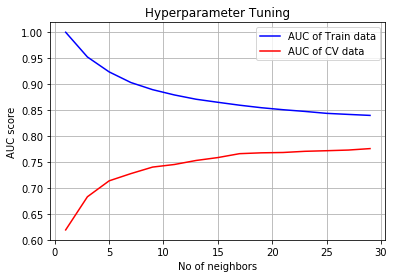

In [113]:
plt.close()
plt.plot(neighbors,bow_bf_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,bow_bf_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (Brute Force) on BoW, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.77

In [115]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="brute",p=2)

# training of model

knn_brute_force_final_model.fit(bow_bf_train,y_train_bf)


#prediction of training data
    
bow_bf_train_pred=knn_brute_force_model.predict_proba(bow_bf_train)
fpr_bow_bf_train,tpr_bow_bf_train,t_bow_bf_train=roc_curve(y_train_bf,bow_bf_train_pred[:,1],pos_label=1)
bow_bf_train_auc_score=roc_auc_score(y_train_bf,bow_bf_train_pred[:,1])
print("The train data AUC score="+str(bow_bf_train_auc_score))
    
# testing of model

bow_bf_test_pred=knn_brute_force_final_model.predict_proba(bow_bf_test)
fpr_bow_bf_test,tpr_bow_bf_test,t_bow_bf_test=roc_curve(y_test_bf,bow_bf_test_pred[:,1],pos_label=1)
bow_bf_test_auc_score=roc_auc_score(y_test_bf,bow_bf_test_pred[:,1])
print("The test data AUC score="+str(bow_bf_test_auc_score))

The train data AUC score=0.8400647382327888
The test data AUC score=0.7648143983719428


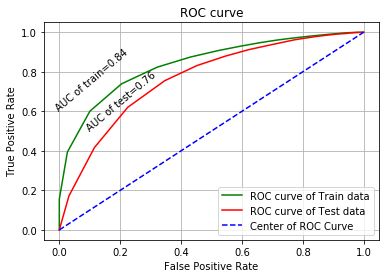

In [339]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_bow_bf_train,tpr_bow_bf_train,"green",label="ROC curve of Train data")
plt.plot(fpr_bow_bf_test,tpr_bow_bf_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.84",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.5,"AUC of test=0.76",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

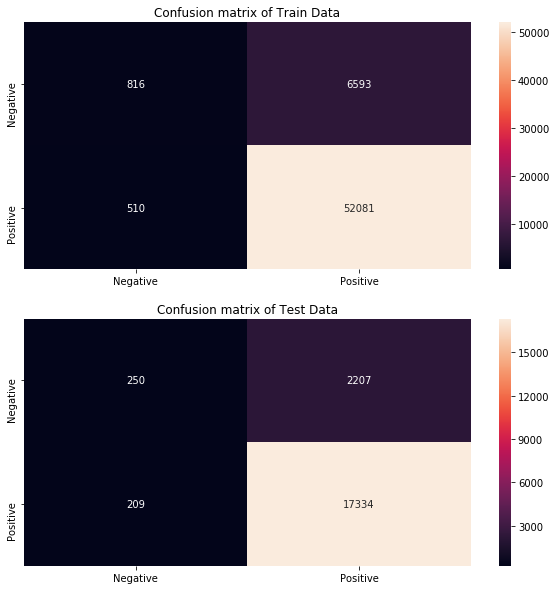

In [269]:
# confusion matrix of Train and Test data
# https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities?rq=1
# plotting confusion matrix: https://seaborn.pydata.org/generated/seaborn.heatmap.html

#  confusion matrix of training data
bow_bf_train_pred_cm=np.argmax(bow_bf_train_pred,axis=1)
bow_bf_train_confusion_matrix=confusion_matrix(y_train_bf,bow_bf_train_pred_cm,labels=[0,1])
bow_bf_train_cm=pd.DataFrame(bow_bf_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

bow_bf_test_pred_cm=np.argmax(bow_bf_test_pred,axis=1)
bow_bf_test_confusion_matrix=confusion_matrix(y_test_bf,bow_bf_test_pred_cm,labels=[0,1])
bow_bf_test_cm=pd.DataFrame(bow_bf_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(bow_bf_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(bow_bf_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.76 of future unseen data

#### 6.2 KNN (Brute Force) on TFIDF

In [165]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_bf_train_auc_score=[]
tfidf_bf_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="brute",p=2)
    knn_brute_force_model.fit(tfidf_bf_train,y_train_bf)
    
    #prediction of training data
    
    tfidf_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_bf_train)
    tfidf_bf_train_auc=roc_auc_score(y_train_bf,tfidf_bf_train_pred[:,1])
    tfidf_bf_train_auc_score.append(tfidf_bf_train_auc)
    
    # prediction of cv data
    
    tfidf_bf_cv_pred=knn_brute_force_model.predict_proba(tfidf_bf_cv)
    tfidf_bf_cv_auc=roc_auc_score(y_cv_bf,tfidf_bf_cv_pred[:,1])
    tfidf_bf_cv_auc_score.append(tfidf_bf_cv_auc)

100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [1:45:07<00:00, 433.12s/it]


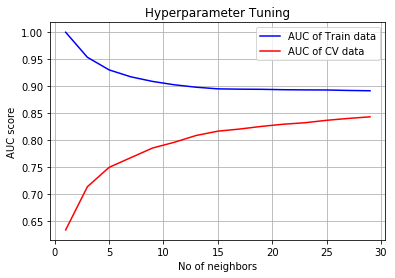

In [166]:
plt.close()
plt.plot(neighbors,tfidf_bf_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_bf_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (Brute Force) on TFIDF, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.84

In [170]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="brute",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_bf_train,y_train_bf)


#prediction of training data
    
tfidf_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_bf_train)
fpr_tfidf_bf_train,tpr_tfidf_bf_train,t_tfidf_bf_train=roc_curve(y_train_bf,tfidf_bf_train_pred[:,1],pos_label=1)
tfidf_bf_train_auc_score=roc_auc_score(y_train_bf,tfidf_bf_train_pred[:,1])
print("The train data AUC score="+str(tfidf_bf_train_auc_score))
    
# testing of model

tfidf_bf_test_pred=knn_brute_force_final_model.predict_proba(tfidf_bf_test)
fpr_tfidf_bf_test,tpr_tfidf_bf_test,t_tfidf_bf_test=roc_curve(y_test_bf,tfidf_bf_test_pred[:,1],pos_label=1)
tfidf_bf_test_auc_score=roc_auc_score(y_test_bf,tfidf_bf_test_pred[:,1])
print("The test data AUC score="+str(tfidf_bf_test_auc_score))

The train data AUC score=0.891502934739199
The test data AUC score=0.8350286734257548


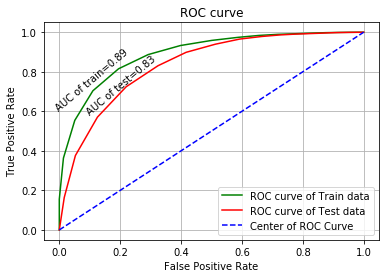

In [337]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_bf_train,tpr_tfidf_bf_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_bf_test,tpr_tfidf_bf_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.89",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.58,"AUC of test=0.83",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

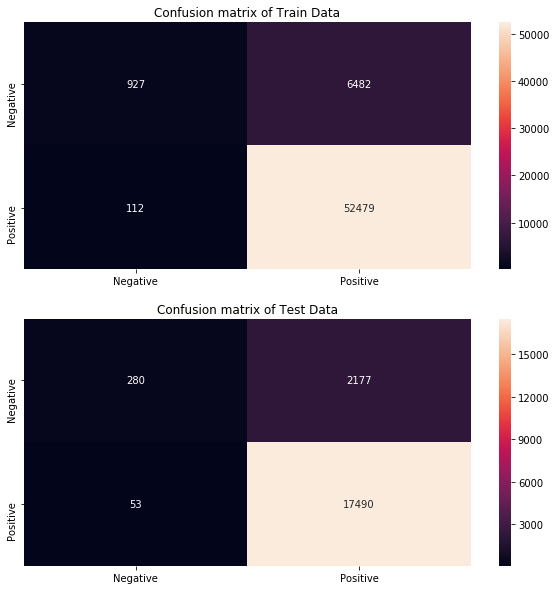

In [270]:
#  confusion matrix of training data
tfidf_bf_train_pred_cm=np.argmax(tfidf_bf_train_pred,axis=1)
tfidf_bf_train_confusion_matrix=confusion_matrix(y_train_bf,tfidf_bf_train_pred_cm,labels=[0,1])
tfidf_bf_train_cm=pd.DataFrame(tfidf_bf_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_bf_test_pred_cm=np.argmax(tfidf_bf_test_pred,axis=1)
tfidf_bf_test_confusion_matrix=confusion_matrix(y_test_bf,tfidf_bf_test_pred_cm,labels=[0,1])
tfidf_bf_test_cm=pd.DataFrame(tfidf_bf_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_bf_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_bf_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.835 of future unseen data

#### 6.3. KNN (Brute Force) on Avg W2V

In [179]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
avg_w2v_bf_train_auc_score=[]
avg_w2v_bf_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="brute",p=2)
    knn_brute_force_model.fit(avg_w2v_train_bf,y_train_bf)
    
    #prediction of training data
    
    avg_w2v_bf_train_pred=knn_brute_force_model.predict_proba(avg_w2v_train_bf)
    avg_w2v_bf_train_auc=roc_auc_score(y_train_bf,avg_w2v_bf_train_pred[:,1])
    avg_w2v_bf_train_auc_score.append(avg_w2v_bf_train_auc)
    
    # prediction of cv data
    
    avg_w2v_bf_cv_pred=knn_brute_force_model.predict_proba(avg_w2v_cv_bf)
    avg_w2v_bf_cv_auc=roc_auc_score(y_cv_bf,avg_w2v_bf_cv_pred[:,1])
    avg_w2v_bf_cv_auc_score.append(avg_w2v_bf_cv_auc)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [49:49<00:00, 209.11s/it]


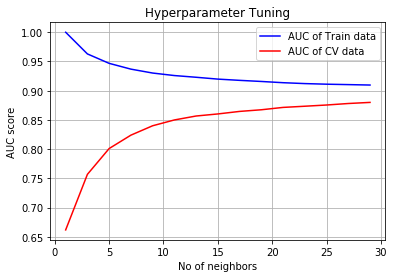

In [180]:
plt.close()
plt.plot(neighbors,avg_w2v_bf_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,avg_w2v_bf_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (Brute Force) on Avg W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.87

In [183]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="brute",p=2)

# training of model

knn_brute_force_final_model.fit(avg_w2v_train_bf,y_train_bf)


#prediction of training data
    
avg_w2v_bf_train_pred=knn_brute_force_model.predict_proba(avg_w2v_train_bf)
fpr_avg_w2v_bf_train,tpr_avg_w2v_bf_train,t_avg_w2v_bf_train=roc_curve(y_train_bf,avg_w2v_bf_train_pred[:,1],pos_label=1)
avg_w2v_bf_train_auc_score=roc_auc_score(y_train_bf,avg_w2v_bf_train_pred[:,1])
print("The train data AUC score="+str(avg_w2v_bf_train_auc_score))
    
# testing of model

avg_w2v_bf_test_pred=knn_brute_force_final_model.predict_proba(avg_w2v_test_bf)
fpr_avg_w2v_bf_test,tpr_avg_w2v_bf_test,t_avg_w2v_bf_test=roc_curve(y_test_bf,avg_w2v_bf_test_pred[:,1],pos_label=1)
avg_w2v_bf_test_auc_score=roc_auc_score(y_test_bf,avg_w2v_bf_test_pred[:,1])
print("The test data AUC score="+str(avg_w2v_bf_test_auc_score))

The train data AUC score=0.9096683270159912
The test data AUC score=0.8699550991063275


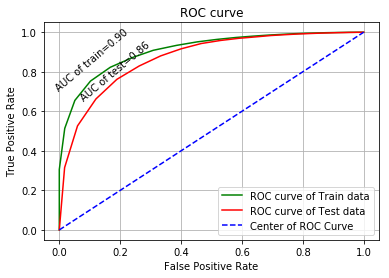

In [335]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_avg_w2v_bf_train,tpr_avg_w2v_bf_train,"green",label="ROC curve of Train data")
plt.plot(fpr_avg_w2v_bf_test,tpr_avg_w2v_bf_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.7,"AUC of train=0.90",rotation=40,rotation_mode='anchor')
plt.text(0.08,0.65,"AUC of test=0.86",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

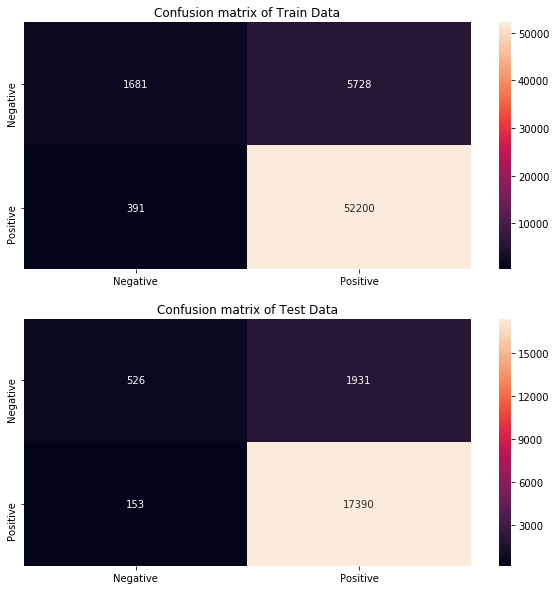

In [271]:
#  confusion matrix of training data
avg_w2v_bf_train_pred_cm=np.argmax(avg_w2v_bf_train_pred,axis=1)
avg_w2v_bf_train_confusion_matrix=confusion_matrix(y_train_bf,avg_w2v_bf_train_pred_cm,labels=[0,1])
avg_w2v_bf_train_cm=pd.DataFrame(avg_w2v_bf_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

avg_w2v_bf_test_pred_cm=np.argmax(avg_w2v_bf_test_pred,axis=1)
avg_w2v_bf_test_confusion_matrix=confusion_matrix(y_test_bf,avg_w2v_bf_test_pred_cm,labels=[0,1])
avg_w2v_bf_test_cm=pd.DataFrame(avg_w2v_bf_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(avg_w2v_bf_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(avg_w2v_bf_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.869 of future unseen data

#### 6.4 KNN (Brute Force) on TFIDF weighted W2V

In [241]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [242]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_cv_bf_im=imp.fit_transform(tfidf_w2v_cv_bf)
tfidf_w2v_test_bf_im=imp.fit_transform(tfidf_w2v_test_bf)

In [244]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_w2v_bf_train_auc_score=[]
tfidf_w2v_bf_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="brute",p=2)
    knn_brute_force_model.fit(tfidf_w2v_train_bf,y_train_bf)
    
    #prediction of training data
    
    tfidf_w2v_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_bf)
    tfidf_w2v_bf_train_auc=roc_auc_score(y_train_bf,tfidf_w2v_bf_train_pred[:,1])
    tfidf_w2v_bf_train_auc_score.append(tfidf_w2v_bf_train_auc)
    
    # prediction of cv data
    
    tfidf_w2v_bf_cv_pred=knn_brute_force_model.predict_proba(tfidf_w2v_cv_bf_im)
    tfidf_w2v_bf_cv_auc=roc_auc_score(y_cv_bf,tfidf_w2v_bf_cv_pred[:,1])
    tfidf_w2v_bf_cv_auc_score.append(tfidf_w2v_bf_cv_auc)


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [49:55<00:00, 209.73s/it]

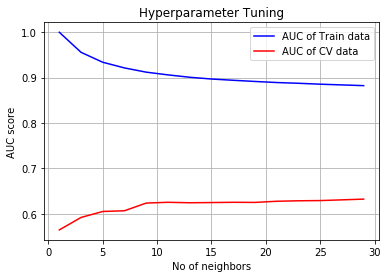

In [252]:
plt.close()
plt.plot(neighbors,tfidf_w2v_bf_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_w2v_bf_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (Brute Force) on TFIDF W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.63

In [254]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="brute",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_w2v_train_bf,y_train_bf)


#prediction of training data
    
tfidf_w2v_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_bf)
fpr_tfidf_w2v_bf_train,tpr_tfidf_w2v_bf_train,t_tfidf_w2v_bf_train=roc_curve(y_train_bf,tfidf_w2v_bf_train_pred[:,1],pos_label=1)
tfidf_w2v_bf_train_auc_score=roc_auc_score(y_train_bf,tfidf_w2v_bf_train_pred[:,1])
print("The train data AUC score="+str(tfidf_w2v_bf_train_auc_score))
    
# testing of model

tfidf_w2v_bf_test_pred=knn_brute_force_final_model.predict_proba(tfidf_w2v_test_bf_im)
fpr_tfidf_w2v_bf_test,tpr_tfidf_w2v_bf_test,t_tfidf_w2v_bf_test=roc_curve(y_test_bf,tfidf_w2v_bf_test_pred[:,1],pos_label=1)
tfidf_w2v_bf_test_auc_score=roc_auc_score(y_test_bf,tfidf_w2v_bf_test_pred[:,1])
print("The test data AUC score="+str(tfidf_w2v_bf_test_auc_score))

The train data AUC score=0.8823900375252486
The test data AUC score=0.6196015576680229


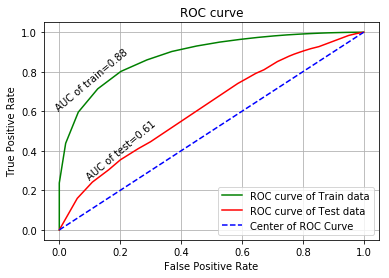

In [329]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_w2v_bf_train,tpr_tfidf_w2v_bf_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_w2v_bf_test,tpr_tfidf_w2v_bf_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.88",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.25,"AUC of test=0.61",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

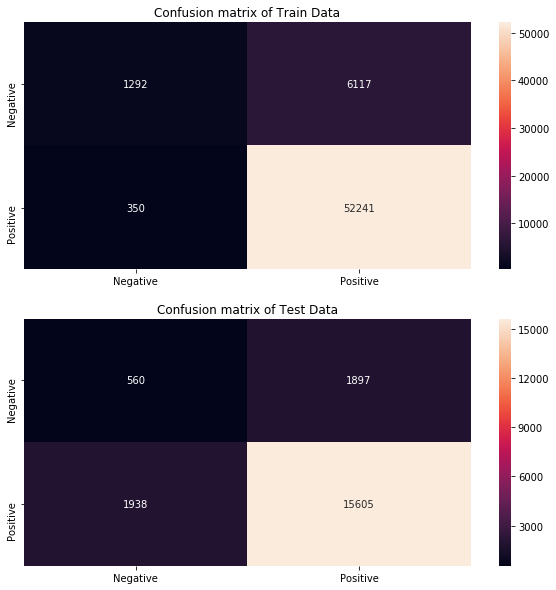

In [272]:
#  confusion matrix of training data
tfidf_w2v_bf_train_pred_cm=np.argmax(tfidf_w2v_bf_train_pred,axis=1)
tfidf_w2v_bf_train_confusion_matrix=confusion_matrix(y_train_bf,tfidf_w2v_bf_train_pred_cm,labels=[0,1])
tfidf_w2v_bf_train_cm=pd.DataFrame(tfidf_w2v_bf_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_w2v_bf_test_pred_cm=np.argmax(tfidf_w2v_bf_test_pred,axis=1)
tfidf_w2v_bf_test_confusion_matrix=confusion_matrix(y_test_bf,tfidf_w2v_bf_test_pred_cm,labels=[0,1])
tfidf_w2v_bf_test_cm=pd.DataFrame(tfidf_w2v_bf_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_w2v_bf_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_w2v_bf_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.62 of future unseen data

### 7. KNN using KD Tree

#### 7.1 KNN (KD Tree) on BoW

In [188]:
# kd tree accepts dense matrix only. so sparse matrix converted into the dense matrix

# training 

dense_bow_kd_train=bow_kd_train.todense()
print(type(dense_bow_kd_train))
print("Shape of Train vector")
print(dense_bow_kd_train.shape)
# cv

dense_bow_kd_cv=bow_kd_cv.todense()
print(type(dense_bow_kd_cv))

#testing

dense_bow_kd_test=bow_kd_test.todense()
print(type(dense_bow_kd_test))

<class 'numpy.matrixlib.defmatrix.matrix'>
Shape of Train vector
(24000, 500)
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


In [189]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
bow_kd_train_auc_score=[]
bow_kd_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",p=2)
    knn_brute_force_model.fit(dense_bow_kd_train,y_train_kd)
    
    #prediction of training data
    
    bow_kd_train_pred=knn_brute_force_model.predict_proba(dense_bow_kd_train)
    bow_kd_train_auc=roc_auc_score(y_train_kd,bow_kd_train_pred[:,1])
    bow_kd_train_auc_score.append(bow_kd_train_auc)
    
    # prediction of cv data
    
    bow_kd_cv_pred=knn_brute_force_model.predict_proba(dense_bow_kd_cv)
    bow_kd_cv_auc=roc_auc_score(y_cv_kd,bow_kd_cv_pred[:,1])
    bow_kd_cv_auc_score.append(bow_kd_cv_auc)


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [3:53:14<00:00, 929.81s/it]

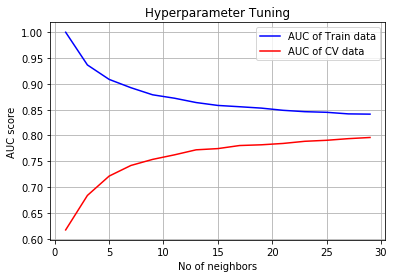

In [190]:
plt.close()
plt.plot(neighbors,bow_kd_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,bow_kd_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (KD Tree) on BoW, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.79

In [193]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="kd_tree",p=2)

# training of model

knn_brute_force_final_model.fit(dense_bow_kd_train,y_train_kd)


#prediction of training data
    
bow_kd_train_pred=knn_brute_force_model.predict_proba(dense_bow_kd_train)
fpr_bow_kd_train,tpr_bow_kd_train,t_bow_kd_train=roc_curve(y_train_kd,bow_kd_train_pred[:,1],pos_label=1)
bow_kd_train_auc_score=roc_auc_score(y_train_kd,bow_kd_train_pred[:,1])
print("The train data AUC score="+str(bow_kd_train_auc_score))
    
# testing of model

bow_kd_test_pred=knn_brute_force_final_model.predict_proba(dense_bow_kd_test)
fpr_bow_kd_test,tpr_bow_kd_test,t_bow_kd_test=roc_curve(y_test_kd,bow_kd_test_pred[:,1],pos_label=1)
bow_kd_test_auc_score=roc_auc_score(y_test_kd,bow_kd_test_pred[:,1])
print("The test data AUC score="+str(bow_kd_test_auc_score))

The train data AUC score=0.8413611245924351
The test data AUC score=0.7828839039445228


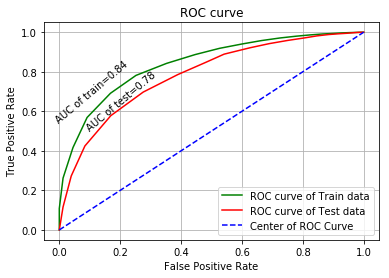

In [327]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_bow_kd_train,tpr_bow_kd_train,"green",label="ROC curve of Train data")
plt.plot(fpr_bow_kd_test,tpr_bow_kd_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.54,"AUC of train=0.84",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.5,"AUC of test=0.78",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

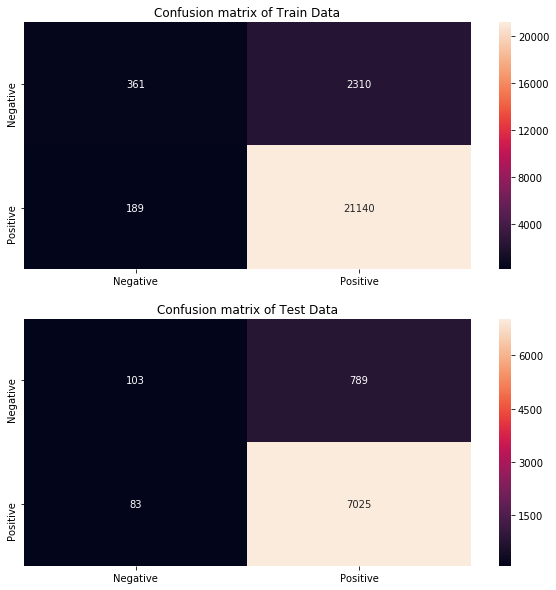

In [273]:
#  confusion matrix of training data
bow_kd_train_pred_cm=np.argmax(bow_kd_train_pred,axis=1)
bow_kd_train_confusion_matrix=confusion_matrix(y_train_kd,bow_kd_train_pred_cm,labels=[0,1])
bow_kd_train_cm=pd.DataFrame(bow_kd_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

bow_kd_test_pred_cm=np.argmax(bow_kd_test_pred,axis=1)
bow_kd_test_confusion_matrix=confusion_matrix(y_test_kd,bow_kd_test_pred_cm,labels=[0,1])
bow_kd_test_cm=pd.DataFrame(bow_kd_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(bow_kd_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(bow_kd_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.782 of future unseen data

#### 7.2 KNN (KD Tree) on TFIDF

In [196]:
# kd tree accepts dense matrix only. so sparse matrix converted into the dense matrix

# training 

dense_tfidf_kd_train=tfidf_kd_train.todense()
print(type(dense_tfidf_kd_train))
print("Shape of Train vector")
print(dense_tfidf_kd_train.shape)
# cv

dense_tfidf_kd_cv=tfidf_kd_cv.todense()
print(type(dense_tfidf_kd_cv))

#testing

dense_tfidf_kd_test=tfidf_kd_test.todense()
print(type(dense_tfidf_kd_test))

<class 'numpy.matrixlib.defmatrix.matrix'>
Shape of Train vector
(24000, 500)
<class 'numpy.matrixlib.defmatrix.matrix'>
<class 'numpy.matrixlib.defmatrix.matrix'>


In [199]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_kd_train_auc_score=[]
tfidf_kd_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",p=2)
    knn_brute_force_model.fit(dense_tfidf_kd_train,y_train_kd)
    
    #prediction of training data
    
    tfidf_kd_train_pred=knn_brute_force_model.predict_proba(dense_tfidf_kd_train)
    tfidf_kd_train_auc=roc_auc_score(y_train_kd,tfidf_kd_train_pred[:,1])
    tfidf_kd_train_auc_score.append(tfidf_kd_train_auc)
    
    # prediction of cv data
    
    tfidf_kd_cv_pred=knn_brute_force_model.predict_proba(dense_tfidf_kd_cv)
    tfidf_kd_cv_auc=roc_auc_score(y_cv_kd,tfidf_kd_cv_pred[:,1])
    tfidf_kd_cv_auc_score.append(tfidf_kd_cv_auc)


100%|███████████████████████████████████████████████████████████████████████████████| 15/15 [3:48:43<00:00, 934.59s/it]

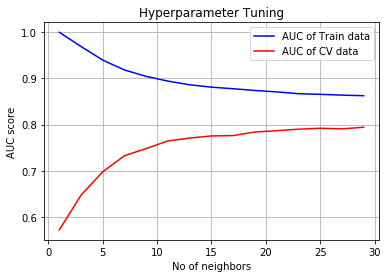

In [200]:
plt.close()
plt.plot(neighbors,tfidf_kd_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_kd_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (KD Tree) on TFIDF, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.79

In [204]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="kd_tree",p=2)

# training of model

knn_brute_force_final_model.fit(dense_tfidf_kd_train,y_train_kd)


#prediction of training data
    
tfidf_kd_train_pred=knn_brute_force_model.predict_proba(dense_tfidf_kd_train)
fpr_tfidf_kd_train,tpr_tfidf_kd_train,t_tfidf_kd_train=roc_curve(y_train_kd,tfidf_kd_train_pred[:,1],pos_label=1)
tfidf_kd_train_auc_score=roc_auc_score(y_train_kd,tfidf_kd_train_pred[:,1])
print("The train data AUC score="+str(tfidf_kd_train_auc_score))
    
# testing of model

tfidf_kd_test_pred=knn_brute_force_final_model.predict_proba(dense_tfidf_kd_test)
fpr_tfidf_kd_test,tpr_tfidf_kd_test,t_tfidf_kd_test=roc_curve(y_test_kd,tfidf_kd_test_pred[:,1],pos_label=1)
tfidf_kd_test_auc_score=roc_auc_score(y_test_kd,tfidf_kd_test_pred[:,1])
print("The test data AUC score="+str(tfidf_kd_test_auc_score))

The train data AUC score=0.8624443189236591
The test data AUC score=0.7834257521998834


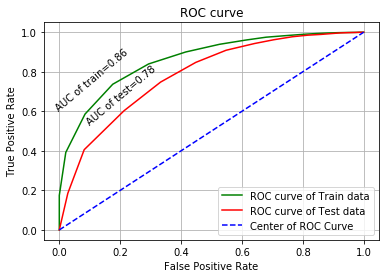

In [321]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_kd_train,tpr_tfidf_kd_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_kd_test,tpr_tfidf_kd_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.86",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.53,"AUC of test=0.78",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

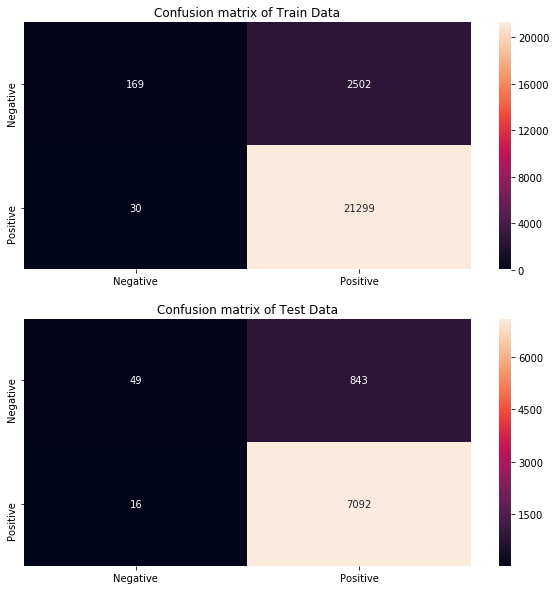

In [274]:
#  confusion matrix of training data
tfidf_kd_train_pred_cm=np.argmax(tfidf_kd_train_pred,axis=1)
tfidf_kd_train_confusion_matrix=confusion_matrix(y_train_kd,tfidf_kd_train_pred_cm,labels=[0,1])
tfidf_kd_train_cm=pd.DataFrame(tfidf_kd_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_kd_test_pred_cm=np.argmax(tfidf_kd_test_pred,axis=1)
tfidf_kd_test_confusion_matrix=confusion_matrix(y_test_kd,tfidf_kd_test_pred_cm,labels=[0,1])
tfidf_kd_test_cm=pd.DataFrame(tfidf_kd_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_kd_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_kd_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.78 of future unseen data

#### 7.3 KNN (KD Tree) on Avg Word2Vec

In [208]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
avg_w2v_kd_train_auc_score=[]
avg_w2v_kd_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",p=2)
    knn_brute_force_model.fit(avg_w2v_train_kd,y_train_kd)
    
    #prediction of training data
    
    avg_w2v_kd_train_pred=knn_brute_force_model.predict_proba(avg_w2v_train_kd)
    avg_w2v_kd_train_auc=roc_auc_score(y_train_kd,avg_w2v_kd_train_pred[:,1])
    avg_w2v_kd_train_auc_score.append(avg_w2v_kd_train_auc)
    
    # prediction of cv data
    
    avg_w2v_kd_cv_pred=knn_brute_force_model.predict_proba(avg_w2v_cv_kd)
    avg_w2v_kd_cv_auc=roc_auc_score(y_cv_kd,avg_w2v_kd_cv_pred[:,1])
    avg_w2v_kd_cv_auc_score.append(avg_w2v_kd_cv_auc)


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [38:20<00:00, 157.52s/it]

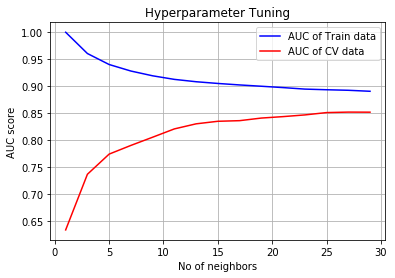

In [209]:
plt.close()
plt.plot(neighbors,avg_w2v_kd_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,avg_w2v_kd_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (KD Tree) on Avg W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.85

In [213]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="kd_tree",p=2)

# training of model

knn_brute_force_final_model.fit(avg_w2v_train_kd,y_train_kd)


#prediction of training data
    
avg_w2v_kd_train_pred=knn_brute_force_model.predict_proba(avg_w2v_train_kd)
fpr_avg_w2v_kd_train,tpr_avg_w2v_kd_train,t_avg_w2v_kd_train=roc_curve(y_train_kd,avg_w2v_kd_train_pred[:,1],pos_label=1)
avg_w2v_kd_train_auc_score=roc_auc_score(y_train_kd,avg_w2v_kd_train_pred[:,1])
print("The train data AUC score="+str(avg_w2v_kd_train_auc_score))
    
# testing of model

avg_w2v_kd_test_pred=knn_brute_force_final_model.predict_proba(avg_w2v_test_kd)
fpr_avg_w2v_kd_test,tpr_avg_w2v_kd_test,t_avg_w2v_kd_test=roc_curve(y_test_kd,avg_w2v_kd_test_pred[:,1],pos_label=1)
avg_w2v_kd_test_auc_score=roc_auc_score(y_test_kd,avg_w2v_kd_test_pred[:,1])
print("The test data AUC score="+str(avg_w2v_kd_test_auc_score))

The train data AUC score=0.8908078845831171
The test data AUC score=0.8412413790057814


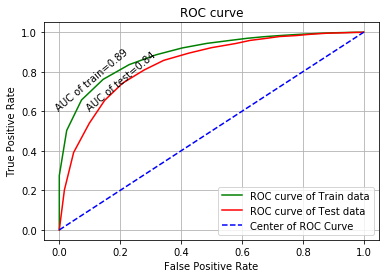

In [340]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_avg_w2v_kd_train,tpr_avg_w2v_kd_train,"green",label="ROC curve of Train data")
plt.plot(fpr_avg_w2v_kd_test,tpr_avg_w2v_kd_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.89",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.6,"AUC of test=0.84",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

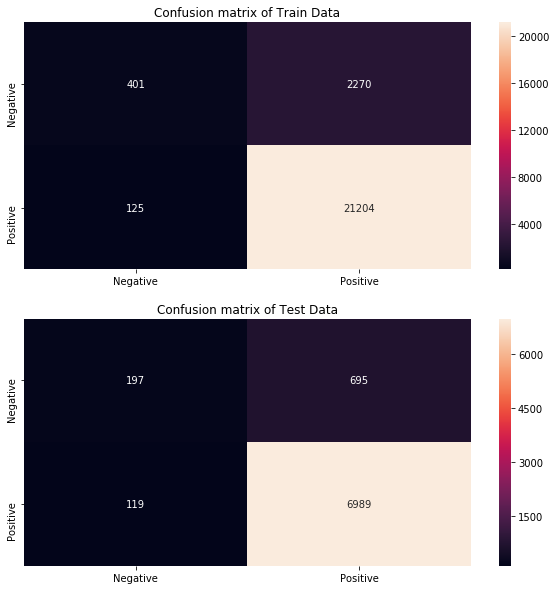

In [275]:
#  confusion matrix of training data
avg_w2v_kd_train_pred_cm=np.argmax(avg_w2v_kd_train_pred,axis=1)
avg_w2v_kd_train_confusion_matrix=confusion_matrix(y_train_kd,avg_w2v_kd_train_pred_cm,labels=[0,1])
avg_w2v_kd_train_cm=pd.DataFrame(avg_w2v_kd_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

avg_w2v_kd_test_pred_cm=np.argmax(avg_w2v_kd_test_pred,axis=1)
avg_w2v_kd_test_confusion_matrix=confusion_matrix(y_test_kd,avg_w2v_kd_test_pred_cm,labels=[0,1])
avg_w2v_kd_test_cm=pd.DataFrame(avg_w2v_kd_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(avg_w2v_kd_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(avg_w2v_kd_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.84 of future unseen data

#### 7.4 KNN (KD Tree) on TFIDF weighted W2V

In [223]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [229]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_cv_kd_im=imp.fit_transform(tfidf_w2v_cv_kd)
tfidf_w2v_test_kd_im=imp.fit_transform(tfidf_w2v_test_kd)

In [303]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_w2v_kd_train_auc_score=[]
tfidf_w2v_kd_cv_auc_score=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",p=2)
    knn_brute_force_model.fit(tfidf_w2v_train_kd,y_train_kd)
    
    #prediction of training data
    
    tfidf_w2v_kd_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_kd)
    tfidf_w2v_kd_train_auc=roc_auc_score(y_train_kd,tfidf_w2v_kd_train_pred[:,1])
    tfidf_w2v_kd_train_auc_score.append(tfidf_w2v_kd_train_auc)
    
    # prediction of cv data
    
    tfidf_w2v_kd_cv_pred=knn_brute_force_model.predict_proba(tfidf_w2v_cv_kd_im)
    tfidf_w2v_kd_cv_auc=roc_auc_score(y_cv_kd,tfidf_w2v_kd_cv_pred[:,1])
    tfidf_w2v_kd_cv_auc_score.append(tfidf_w2v_kd_cv_auc)


100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [32:19<00:00, 143.57s/it]

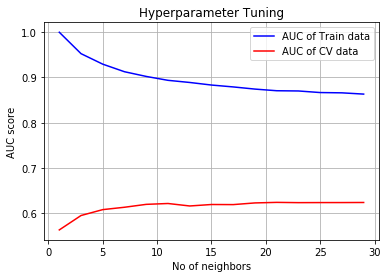

In [304]:
plt.close()
plt.plot(neighbors,tfidf_w2v_kd_train_auc_score,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_w2v_kd_cv_auc_score,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (KD Tree) on TFIDF W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.62

In [238]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="kd_tree",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_w2v_train_kd,y_train_kd)


#prediction of training data
    
tfidf_w2v_kd_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_kd)
fpr_tfidf_w2v_kd_train,tpr_tfidf_w2v_kd_train,t_tfidf_w2v_kd_train=roc_curve(y_train_kd,tfidf_w2v_kd_train_pred[:,1],pos_label=1)
tfidf_w2v_kd_train_auc_score=roc_auc_score(y_train_kd,tfidf_w2v_kd_train_pred[:,1])
print("The train data AUC score="+str(tfidf_w2v_kd_train_auc_score))
    
# testing of model

tfidf_w2v_kd_test_pred=knn_brute_force_final_model.predict_proba(tfidf_w2v_test_kd_im)
fpr_tfidf_w2v_kd_test,tpr_tfidf_w2v_kd_test,t_tfidf_w2v_kd_test=roc_curve(y_test_kd,tfidf_w2v_kd_test_pred[:,1],pos_label=1)
tfidf_w2v_kd_test_auc_score=roc_auc_score(y_test_kd,tfidf_w2v_kd_test_pred[:,1])
print("The test data AUC score="+str(tfidf_w2v_kd_test_auc_score))

The train data AUC score=0.8633030288929255
The test data AUC score=0.6110833085186652


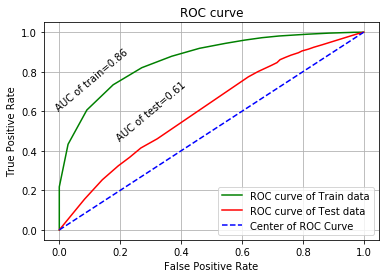

In [342]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_w2v_kd_train,tpr_tfidf_w2v_kd_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_w2v_kd_test,tpr_tfidf_w2v_kd_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.86",rotation=40,rotation_mode='anchor')
plt.text(0.2,0.45,"AUC of test=0.61",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

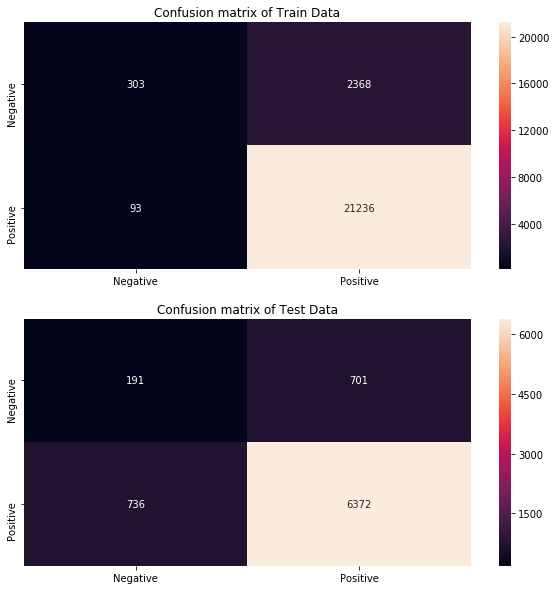

In [276]:
#  confusion matrix of training data
tfidf_w2v_kd_train_pred_cm=np.argmax(tfidf_w2v_kd_train_pred,axis=1)
tfidf_w2v_kd_train_confusion_matrix=confusion_matrix(y_train_kd,tfidf_w2v_kd_train_pred_cm,labels=[0,1])
tfidf_w2v_kd_train_cm=pd.DataFrame(tfidf_w2v_kd_train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_w2v_kd_test_pred_cm=np.argmax(tfidf_w2v_kd_test_pred,axis=1)
tfidf_w2v_kd_test_confusion_matrix=confusion_matrix(y_test_kd,tfidf_w2v_kd_test_pred_cm,labels=[0,1])
tfidf_w2v_kd_test_cm=pd.DataFrame(tfidf_w2v_kd_test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_w2v_kd_train_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_w2v_kd_test_cm,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.61 of future unseen data

### Observation:

In [302]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [258]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]

x.add_row(["BOW","Brute Force",27,0.76])
x.add_row(["TFIDF","Brute Force",27,0.83])
x.add_row(["Avg W2V","Brute Force",27,0.86])
x.add_row(["TFIDF W2V","Brute Force",27,0.62])
x.add_row(["BOW","KD Tree",27,0.78])
x.add_row(["TFIDF","KD Tree",27,0.78])
x.add_row(["Avg W2V","KD Tree",27,0.84])
x.add_row(["TFIDF W2V","KD Tree",27,0.61])
print(x)

+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
|    BOW     | Brute Force |       27       | 0.76 |
|   TFIDF    | Brute Force |       27       | 0.83 |
|  Avg W2V   | Brute Force |       27       | 0.86 |
| TFIDF W2V  | Brute Force |       27       | 0.62 |
|    BOW     |   KD Tree   |       27       | 0.78 |
|   TFIDF    |   KD Tree   |       27       | 0.78 |
|  Avg W2V   |   KD Tree   |       27       | 0.84 |
| TFIDF W2V  |   KD Tree   |       27       | 0.61 |
+------------+-------------+----------------+------+


### 8. Feature Engineering(FE)

### 8.1 Adding Summary Text as a Feature with Review Text:

* The TFIDF weighted Word2Vec KNN model gives less accuracy compared to other models. So we need to improve model accuracy using feature engineering. 
* we consider summary text as a feature,we do preprocessing and featurization on the summary text and then we horizontally stack the summary text to the review text. so finally we get the extra word vector to improve our model

#### 8.1.1 Summary Text Preprocessing

In [176]:
raw_summary_text_data=filter_data.Summary.values

In [177]:
raw_summary_text_data

array(['EVERY book is educational',
       'This whole series is great way to spend time with your child',
       'Entertainingl Funny!', ..., 'my dogs love the peanut butter!',
       'Disappointed', 'Awesome!!!'], dtype=object)

In [178]:
preprocessed_summary_text_data=[]
for i in tqdm(raw_summary_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alphA_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_summary_text_data.append(b' '.join(k).decode())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:45<00:00, 7968.35it/s]


In [179]:
filter_data.Summary=preprocessed_summary_text_data

In [180]:
filter_data

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Length
138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,1,939340800,everi book educ,witti littl book make son laugh loud recit car...,35
138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,1,940809600,whole seri great way spend time child,rememb see show air televis year ago child sis...,35
417839,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,1,944092800,entertainingl funni,beetlejuic well written movi everyth excel act...,13
212472,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,1,944438400,modern day fairi tale,twist rumplestiskin captur film star michael k...,21
417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,1,946857600,fantast,beetlejuic excel funni movi keaton hilari wack...,25
212533,230348,B00004RYGX,A1048CYU0OV4O8,Judy L. Eans,2,2,1,947376000,great,one movi movi collect fill comedi action whate...,11
212458,230269,B00004RYGX,A1B2IZU1JLZA6,Wes,19,23,0,948240000,warn clamshel edit edit tv version,alway enjoy movi funni entertain not hesit pic...,32
70688,76882,B00002N8SM,A32DW342WBJ6BX,Buttersugar,0,0,1,948672000,sure death fli,bought apart infest fruit fli hour trap quot a...,33
212558,230376,B00004RYGX,ACJR7EQF9S6FP,Jeremy Robertson,2,3,1,951523200,bettlejuic bettlejuic bettlejuic,happen say name three time michael keaten star...,108
212511,230326,B00004RYGX,A2DEE7F9XKP3ZR,jerome,0,3,1,959990400,research beatlejuic video french version,get crazi look beatlejuic french version video...,22


#### 8.1.2 Data Splitting

#### Data Splitting for Brute Force

In [181]:
X_bf_s=final_data_bf.Summary
Y_bf_s=final_data_bf.Score

x_1_s,x_test_bf_s,y_1_s,y_test_bf_s=train_test_split(X_bf_s,Y_bf_s,test_size=0.2,random_state=40)
x_train_bf_s,x_cv_bf_s,y_train_bf_s,y_cv_bf_s=train_test_split(x_1_s,y_1_s,test_size=0.25,random_state=40)

In [182]:
print(" the shape of train data")
print(x_train_bf_s.shape)
print("the shape of cv data")
print(x_cv_bf_s.shape)
print("the shape of test data")
print(x_test_bf_s.shape)

 the shape of train data
(60000,)
the shape of cv data
(20000,)
the shape of test data
(20000,)


#### Data Splitting for KD Tree

In [183]:
X_kd_s=final_data_kd.Summary
Y_kd_s=final_data_kd.Score

x_2_s,x_test_kd_s,y_2_s,y_test_kd_s=train_test_split(X_kd_s,Y_kd_s,test_size=0.2,random_state=40)
x_train_kd_s,x_cv_kd_s,y_train_kd_s,y_cv_kd_s=train_test_split(x_2_s,y_2_s,test_size=0.25,random_state=40)

In [184]:
print(" the shape of train data")
print(x_train_kd_s.shape)
print("the shape of cv data")
print(x_cv_kd_s.shape)
print("the shape of test data")
print(x_test_kd_s.shape)

 the shape of train data
(24000,)
the shape of cv data
(8000,)
the shape of test data
(8000,)


#### 8.1.3 Featurization

#### 8.1.3.1 Word2Vec

#### Word2Vec for Brute Force

In [185]:
# Word2Vec model on training data

list_sentences_train_bf_s=[]
for i in tqdm(list(x_train_bf_s)):
    list_sentences_train_bf_s.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 441245.58it/s]


In [186]:
word2vec_model_bf_s=Word2Vec(list_sentences_train_bf_s,size=50,workers=4)

In [187]:
word2vec_words_train_bf_s=list(word2vec_model_bf_s.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_bf_s))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_bf_s[100:150])

 Number of words
_________________
 
2757
 sample words
_________________
 
['strong', 'yummmmmm', 'nectar', 'nice', 'select', 'confus', 'keurig', 'organ', 'black', 'cherri', 'concentr', 'must', 'work', 'food', 'make', 'go', 'yeah', 'move', 'rice', 'krispi', 'treat', 'barbequ', 'chip', 'green', 'bowl', 'edibl', 'pet', 'health', 'risk', 'get', 'unexpect', 'guest', 'super', 'deal', 'anyon', 'need', 'gluten', 'favorit', 'no', 'raspberri', 'celesti', 'season', 'garden', 'refresh', 'tasti', 'light', 'kiwi', 'low', 'caffein', 'hand']


In [188]:
# list of sentences cv data

list_sentences_cv_bf_s=[]
for i in tqdm(list(x_cv_bf_s)):
    list_sentences_cv_bf_s.append(i.split())

# list of sentences test data

list_sentences_test_bf_s=[]
for i in tqdm(list(x_test_bf_s)):
    list_sentences_test_bf_s.append(i.split())

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 62727.48it/s]


#### Word2Vec for KD Tree 

In [189]:
# word2vec on training data

list_sentences_train_kd_s=[]
for i in tqdm(list(x_train_kd_s)):
    list_sentences_train_kd_s.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 24000/24000 [00:00<00:00, 461590.96it/s]


In [190]:
word2vec_model_kd_s=Word2Vec(list_sentences_train_kd_s,size=50,workers=4)

In [191]:
word2vec_words_train_kd_s=list(word2vec_model_kd_s.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_kd_s))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_kd_s[100:150])

 Number of words
_________________
 
1598
 sample words
_________________
 
['noth', 'packag', 'bear', 'bulk', 'tast', 'inconsist', 'appl', 'caramel', 'shape', 'hard', 'crunchi', 'extrem', 'picki', 'eater', 'food', 'sip', 'well', 'save', 'groceri', 'disappoint', 'lawri', 'spaghetti', 'big', 'small', 'mislead', 'name', 'old', 'new', 'natur', 'childhood', 'favorit', 'use', 'spice', 'box', 'case', 'review', 'unbeliev', 'gotta', 'soul', 'rip', 'nice', 'cup', 'healthi', 'salti', 'robust', 'earl', 'grey', 'organ', 'think', 'coffe']


In [192]:
# list of sentences cv data

list_sentences_cv_kd_s=[]
for i in tqdm(list(x_cv_kd_s)):
    list_sentences_cv_kd_s.append(i.split())

# list of sentences test data

list_sentences_test_kd_s=[]
for i in tqdm(list(x_test_kd_s)):
    list_sentences_test_kd_s.append(i.split())

100%|██████████████████████████████████████████████████████████████████████████| 8000/8000 [00:00<00:00, 666847.49it/s]


#### 8.1.3.2 TFIDF Weighted Word2Vec

#### TFIDF Weighted Word2Vec for Brute Force

In [193]:
# tfidf word2vec on training data

model_s=TfidfVectorizer()
tfidf_w2v_model_bf_s=model_s.fit_transform(x_train_bf_s)
tfidf_w2v_s=model_s.get_feature_names()
tfidf_word2vec_train_bf_s=[]
row=0
for i in tqdm(list_sentences_train_bf_s):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_bf_s.wv[w]
            tfidf_freq=tfidf_w2v_model_bf_s[row,tfidf_w2v_s.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_bf_s.append(vec)
    row=row+1
tfidf_w2v_train_bf_s=np.asmatrix(tfidf_word2vec_train_bf_s)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_bf_s.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:41<00:00, 1430.75it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [194]:
# tfidf word2vec on cv data
tfidf_w2v_model_bf_s=model_s.transform(x_cv_bf_s)
tfidf_word2vec_cv_bf_s=[]
row=0
for i in tqdm(list_sentences_cv_bf_s):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_bf_s.wv[w]
            tfidf_freq=tfidf_w2v_model_bf_s[row,tfidf_w2v_s.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_bf_s.append(vec)
    row=row+1
tfidf_w2v_cv_bf_s=np.asmatrix(tfidf_word2vec_cv_bf_s)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_bf_s.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1554.81it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [195]:
# tfidf word2vec on test data
tfidf_w2v_model_bf_s=model_s.transform(x_test_bf_s)
tfidf_word2vec_test_bf_s=[]
row=0
for i in tqdm(list_sentences_test_bf_s):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_bf_s.wv[w]
            tfidf_freq=tfidf_w2v_model_bf_s[row,tfidf_w2v_s.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_bf_s.append(vec)
    row=row+1
tfidf_w2v_test_bf_s=np.asmatrix(tfidf_word2vec_test_bf_s)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_bf_s.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1641.60it/s]


Shape of TFIDF word2vec test
(20000, 50)


#### TFIDF Weighted Word2Vec for KD Tree

In [196]:
# tfidf word2vec on training data

model_s=TfidfVectorizer()
tfidf_w2v_model_kd_s=model_s.fit_transform(x_train_kd_s)
tfidf_w2v_kd_s=model_s.get_feature_names()
tfidf_word2vec_train_kd_s=[]
row=0
for i in tqdm(list_sentences_train_kd_s):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_kd_s.wv[w]
            tfidf_freq=tfidf_w2v_model_kd_s[row,tfidf_w2v_kd_s.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_kd_s.append(vec)
    row=row+1
tfidf_w2v_train_kd_s=np.asmatrix(tfidf_word2vec_train_kd_s)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_kd_s.shape)

100%|██████████████████████████████████████████████████████████████████████████| 24000/24000 [00:10<00:00, 2361.62it/s]


Shape of TFIDF word2vec train
(24000, 50)


In [197]:
# tfidf word2vec on cv data
tfidf_w2v_model_kd_s=model_s.transform(x_cv_kd_s)
tfidf_word2vec_cv_kd_s=[]
row=0
for i in tqdm(list_sentences_cv_kd_s):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_kd_s.wv[w]
            tfidf_freq=tfidf_w2v_model_kd_s[row,tfidf_w2v_kd_s.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_kd_s.append(vec)
    row=row+1
tfidf_w2v_cv_kd_s=np.asmatrix(tfidf_word2vec_cv_kd_s)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_kd_s.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2368.29it/s]


Shape of TFIDF word2vec cv
(8000, 50)


In [198]:
# tfidf word2vec on test data
tfidf_w2v_model_kd_s=model_s.transform(x_test_kd_s)
tfidf_word2vec_test_kd_s=[]
row=0
for i in tqdm(list_sentences_test_kd_s):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_kd_s.wv[w]
            tfidf_freq=tfidf_w2v_model_kd_s[row,tfidf_w2v_kd_s.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_kd_s.append(vec)
    row=row+1
tfidf_w2v_test_kd_s=np.asmatrix(tfidf_word2vec_test_kd_s)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_kd_s.shape)

100%|████████████████████████████████████████████████████████████████████████████| 8000/8000 [00:03<00:00, 2128.77it/s]


Shape of TFIDF word2vec test
(8000, 50)


#### 8.1.4 Horizontally stacking the data

In [199]:
# References 
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html
# https://www.geeksforgeeks.org/numpy-hstack-in-python/

#### FE for Brute force

In [200]:
# For Training Data

tfidf_w2v_train_bf_fe=np.hstack((tfidf_w2v_train_bf,tfidf_w2v_train_bf_s))
print("shape of TFIDF W2V train after FE")
print(tfidf_w2v_train_bf_fe.shape)

# For cv Data

tfidf_w2v_cv_bf_fe=np.hstack((tfidf_w2v_cv_bf,tfidf_w2v_cv_bf_s))
print("shape of TFIDF W2V cv after FE")
print(tfidf_w2v_cv_bf_fe.shape)

# For test Data

tfidf_w2v_test_bf_fe=np.hstack((tfidf_w2v_test_bf,tfidf_w2v_test_bf_s))
print("shape of TFIDF W2V test after FE")
print(tfidf_w2v_test_bf_fe.shape)

shape of TFIDF W2V train after FE
(60000, 100)
shape of TFIDF W2V cv after FE
(20000, 100)
shape of TFIDF W2V test after FE
(20000, 100)


#### FE for KD Tree 

In [201]:
# For Training Data

tfidf_w2v_train_kd_fe=np.hstack((tfidf_w2v_train_kd,tfidf_w2v_train_kd_s))
print("shape of TFIDF W2V train after FE")
print(tfidf_w2v_train_kd_fe.shape)

# For cv Data

tfidf_w2v_cv_kd_fe=np.hstack((tfidf_w2v_cv_kd,tfidf_w2v_cv_kd_s))
print("shape of TFIDF W2V cv after FE")
print(tfidf_w2v_cv_kd_fe.shape)

# For test Data

tfidf_w2v_test_kd_fe=np.hstack((tfidf_w2v_test_kd,tfidf_w2v_test_kd_s))
print("shape of TFIDF W2V test after FE")
print(tfidf_w2v_test_kd_fe.shape)

shape of TFIDF W2V train after FE
(24000, 100)
shape of TFIDF W2V cv after FE
(8000, 100)
shape of TFIDF W2V test after FE
(8000, 100)


#### 8.1.5 KNN using TFIDF W2V

#### Brute Force

In [203]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [204]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_bf_im_fe=imp.fit_transform(tfidf_w2v_train_bf_fe)
tfidf_w2v_cv_bf_im_fe=imp.fit_transform(tfidf_w2v_cv_bf_fe)
tfidf_w2v_test_bf_im_fe=imp.fit_transform(tfidf_w2v_test_bf_fe)

In [144]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_w2v_bf_train_auc_score_fe=[]
tfidf_w2v_bf_cv_auc_score_fe=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="brute",p=2)
    knn_brute_force_model.fit(tfidf_w2v_train_bf_im_fe,y_train_bf)
    
    #prediction of training data
    
    tfidf_w2v_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_bf_im_fe)
    tfidf_w2v_bf_train_auc=roc_auc_score(y_train_bf,tfidf_w2v_bf_train_pred[:,1])
    tfidf_w2v_bf_train_auc_score_fe.append(tfidf_w2v_bf_train_auc)
    
    # prediction of cv data
    
    tfidf_w2v_bf_cv_pred=knn_brute_force_model.predict_proba(tfidf_w2v_cv_bf_im_fe)
    tfidf_w2v_bf_cv_auc=roc_auc_score(y_cv_bf,tfidf_w2v_bf_cv_pred[:,1])
    tfidf_w2v_bf_cv_auc_score_fe.append(tfidf_w2v_bf_cv_auc)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [55:33<00:00, 225.23s/it]


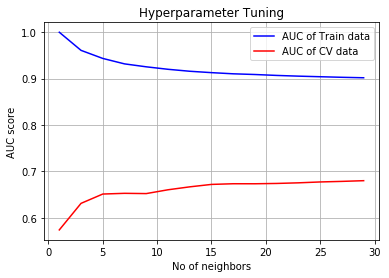

In [145]:
plt.close()
plt.plot(neighbors,tfidf_w2v_bf_train_auc_score_fe,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_w2v_bf_cv_auc_score_fe,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (Brute Force) on FE-TFIDF W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.68

In [147]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="brute",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_w2v_train_bf_im_fe,y_train_bf)


#prediction of training data
    
tfidf_w2v_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_bf_im_fe)
fpr_tfidf_w2v_bf_train,tpr_tfidf_w2v_bf_train,t_tfidf_w2v_bf_train=roc_curve(y_train_bf,tfidf_w2v_bf_train_pred[:,1],pos_label=1)
tfidf_w2v_bf_train_auc_score_fe=roc_auc_score(y_train_bf,tfidf_w2v_bf_train_pred[:,1])
print("The train data AUC score after FE ="+str(tfidf_w2v_bf_train_auc_score_fe))
    
# testing of model

tfidf_w2v_bf_test_pred=knn_brute_force_final_model.predict_proba(tfidf_w2v_test_bf_im_fe)
fpr_tfidf_w2v_bf_test,tpr_tfidf_w2v_bf_test,t_tfidf_w2v_bf_test=roc_curve(y_test_bf,tfidf_w2v_bf_test_pred[:,1],pos_label=1)
tfidf_w2v_bf_test_auc_score_fe=roc_auc_score(y_test_bf,tfidf_w2v_bf_test_pred[:,1])
print("The test data AUC score After FE ="+str(tfidf_w2v_bf_test_auc_score_fe))

The train data AUC score after FE =0.9018478415572132
The test data AUC score After FE =0.6742775139571583


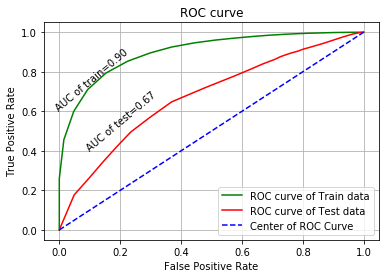

In [154]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_w2v_bf_train,tpr_tfidf_w2v_bf_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_w2v_bf_test,tpr_tfidf_w2v_bf_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.90",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.4,"AUC of test=0.67",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

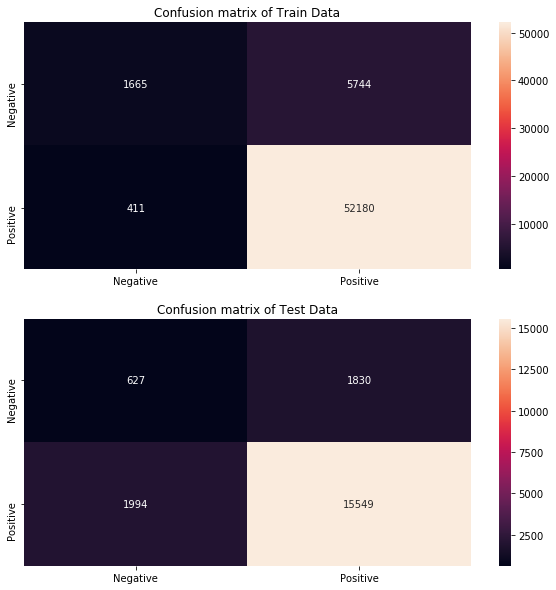

In [155]:
#  confusion matrix of training data
tfidf_w2v_bf_train_pred_cm_fe=np.argmax(tfidf_w2v_bf_train_pred,axis=1)
tfidf_w2v_bf_train_confusion_matrix_fe=confusion_matrix(y_train_bf,tfidf_w2v_bf_train_pred_cm_fe,labels=[0,1])
tfidf_w2v_bf_train_cm_fe=pd.DataFrame(tfidf_w2v_bf_train_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_w2v_bf_test_pred_cm_fe=np.argmax(tfidf_w2v_bf_test_pred,axis=1)
tfidf_w2v_bf_test_confusion_matrix_fe=confusion_matrix(y_test_bf,tfidf_w2v_bf_test_pred_cm_fe,labels=[0,1])
tfidf_w2v_bf_test_cm_fe=pd.DataFrame(tfidf_w2v_bf_test_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_w2v_bf_train_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_w2v_bf_test_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.67 of future unseen data

#### KD Tree

In [157]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer

In [205]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_kd_im_fe=imp.fit_transform(tfidf_w2v_train_kd_fe)
tfidf_w2v_cv_kd_im_fe=imp.fit_transform(tfidf_w2v_cv_kd_fe)
tfidf_w2v_test_kd_im_fe=imp.fit_transform(tfidf_w2v_test_kd_fe)

In [159]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_w2v_kd_train_auc_score_fe=[]
tfidf_w2v_kd_cv_auc_score_fe=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",p=2)
    knn_brute_force_model.fit(tfidf_w2v_train_kd_im_fe,y_train_kd)
    
    #prediction of training data
    
    tfidf_w2v_kd_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_kd_im_fe)
    tfidf_w2v_kd_train_auc=roc_auc_score(y_train_kd,tfidf_w2v_kd_train_pred[:,1])
    tfidf_w2v_kd_train_auc_score_fe.append(tfidf_w2v_kd_train_auc)
    
    # prediction of cv data
    
    tfidf_w2v_kd_cv_pred=knn_brute_force_model.predict_proba(tfidf_w2v_cv_kd_im_fe)
    tfidf_w2v_kd_cv_auc=roc_auc_score(y_cv_kd,tfidf_w2v_kd_cv_pred[:,1])
    tfidf_w2v_kd_cv_auc_score_fe.append(tfidf_w2v_kd_cv_auc)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [55:07<00:00, 241.21s/it]


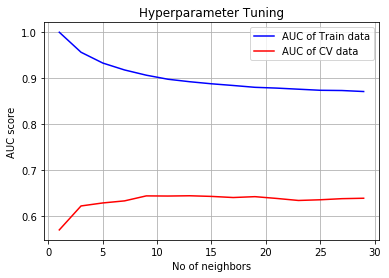

In [160]:
plt.close()
plt.plot(neighbors,tfidf_w2v_kd_train_auc_score_fe,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_w2v_kd_cv_auc_score_fe,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (KD Tree) on TFIDF W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.64

In [162]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="kd_tree",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_w2v_train_kd_im_fe,y_train_kd)


#prediction of training data
    
tfidf_w2v_kd_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_kd_im_fe)
fpr_tfidf_w2v_kd_train,tpr_tfidf_w2v_kd_train,t_tfidf_w2v_kd_train=roc_curve(y_train_kd,tfidf_w2v_kd_train_pred[:,1],pos_label=1)
tfidf_w2v_kd_train_auc_score_fe=roc_auc_score(y_train_kd,tfidf_w2v_kd_train_pred[:,1])
print("The train data AUC score="+str(tfidf_w2v_kd_train_auc_score_fe))
    
# testing of model

tfidf_w2v_kd_test_pred=knn_brute_force_final_model.predict_proba(tfidf_w2v_test_kd_im_fe)
fpr_tfidf_w2v_kd_test,tpr_tfidf_w2v_kd_test,t_tfidf_w2v_kd_test=roc_curve(y_test_kd,tfidf_w2v_kd_test_pred[:,1],pos_label=1)
tfidf_w2v_kd_test_auc_score_fe=roc_auc_score(y_test_kd,tfidf_w2v_kd_test_pred[:,1])
print("The test data AUC score="+str(tfidf_w2v_kd_test_auc_score_fe))

The train data AUC score=0.8708676914009765
The test data AUC score=0.6199028726553293


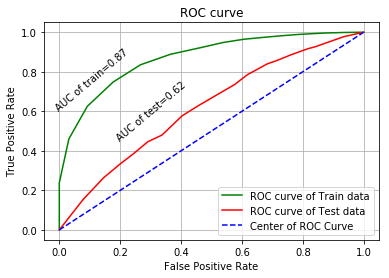

In [163]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_w2v_kd_train,tpr_tfidf_w2v_kd_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_w2v_kd_test,tpr_tfidf_w2v_kd_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.87",rotation=40,rotation_mode='anchor')
plt.text(0.2,0.45,"AUC of test=0.62",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

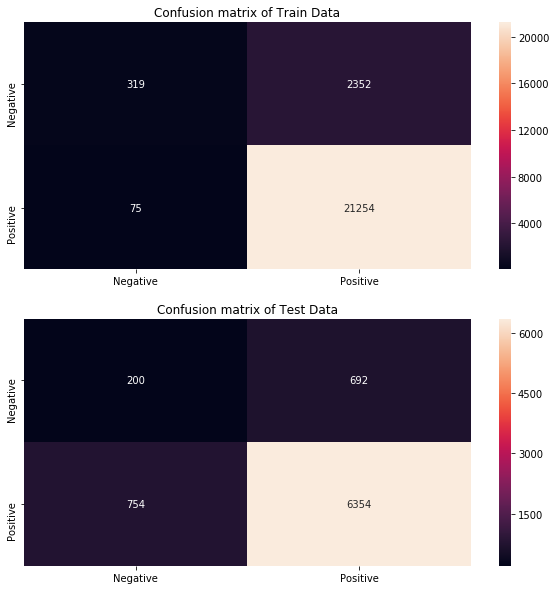

In [164]:
#  confusion matrix of training data
tfidf_w2v_kd_train_pred_cm_fe=np.argmax(tfidf_w2v_kd_train_pred,axis=1)
tfidf_w2v_kd_train_confusion_matrix_fe=confusion_matrix(y_train_kd,tfidf_w2v_kd_train_pred_cm_fe,labels=[0,1])
tfidf_w2v_kd_train_cm_fe=pd.DataFrame(tfidf_w2v_kd_train_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_w2v_kd_test_pred_cm_fe=np.argmax(tfidf_w2v_kd_test_pred,axis=1)
tfidf_w2v_kd_test_confusion_matrix_fe=confusion_matrix(y_test_kd,tfidf_w2v_kd_test_pred_cm_fe,labels=[0,1])
tfidf_w2v_kd_test_cm_fe=pd.DataFrame(tfidf_w2v_kd_test_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_w2v_kd_train_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_w2v_kd_test_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.62 of future unseen data

### 8.1.6 Observation:

In [305]:
x = PrettyTable()
y=PrettyTable()
z=PrettyTable()

print("TFIDF Word2Vec Before Feature Engineering")
y.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
y.add_row(["TFIDF W2V","Brute Force",27,0.62])
y.add_row(["TFIDF W2V","KD Tree",27,0.61])
print(y)

print("TFIDF Word2Vec After Feature Engineering( Review Text + Summary)")
z.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
z.add_row(["TFIDF W2V","Brute Force",27,0.67])
z.add_row(["TFIDF W2V","KD Tree",27,0.62])
print(z)

TFIDF Word2Vec Before Feature Engineering
+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
| TFIDF W2V  | Brute Force |       27       | 0.62 |
| TFIDF W2V  |   KD Tree   |       27       | 0.61 |
+------------+-------------+----------------+------+
TFIDF Word2Vec After Feature Engineering( Review Text + Summary)
+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
| TFIDF W2V  | Brute Force |       27       | 0.67 |
| TFIDF W2V  |   KD Tree   |       27       | 0.62 |
+------------+-------------+----------------+------+


* After applying Feature Engineering on TFIDF Word2Vec Model the AUC score of TFIDF Word2Vec model slightly improved. So We can Improve our model by using of addding summary on text feature.

### 8.2 Adding Review Text length as a feature with Review and Summary Text vector:

In [208]:
# Lengh of the Words in Each Review document

a=[]
for i in preprocessed_text_data:
    a.append(len(i.split()))

In [209]:
# Adding Length as a new Feature in DataFrame

filter_data["Length"]=a

##### 8.2.1Column Standardization using Standardization Formula:

* $\ (Xi-mean)/std $

In [210]:
mean1=filter_data.Length.mean()
std1=filter_data.Length.std()

In [211]:
b=a
c=[]
for i in b:
    stand=(i-mean1)/std1
    c.append(stand)

In [213]:
filter_data.Length=c

#### 8.2.2 Data Splitting

#### Data Splitting for Brute Force

In [218]:
X_bf_l=final_data_bf.Length
Y_bf_l=final_data_bf.Score

x_1_l,x_test_bf_l,y_1_l,y_test_bf_l=train_test_split(X_bf_l,Y_bf_l,test_size=0.2,random_state=40)
x_train_bf_l,x_cv_bf_l,y_train_bf_l,y_cv_bf_l=train_test_split(x_1_l,y_1_l,test_size=0.25,random_state=40)

In [219]:
print(" the shape of train data")
print(x_train_bf_l.shape)
print("the shape of cv data")
print(x_cv_bf_l.shape)
print("the shape of test data")
print(x_test_bf_l.shape)

 the shape of train data
(60000,)
the shape of cv data
(20000,)
the shape of test data
(20000,)


#### Data Splitting for KD Tree

In [286]:
X_kd_l=final_data_kd.Length
Y_kd_l=final_data_kd.Score

x_2_l,x_test_kd_l,y_2_l,y_test_kd_l=train_test_split(X_kd_l,Y_kd_l,test_size=0.2,random_state=40)
x_train_kd_l,x_cv_kd_l,y_train_kd_l,y_cv_kd_l=train_test_split(x_2_l,y_2_l,test_size=0.25,random_state=40)

In [287]:
print(" the shape of train data")
print(x_train_kd_l.shape)
print("the shape of cv data")
print(x_cv_kd_l.shape)
print("the shape of test data")
print(x_test_kd_l.shape)

 the shape of train data
(24000,)
the shape of cv data
(8000,)
the shape of test data
(8000,)


#### 8.2.3 Horizontally stacking the data

#### For Brute Force

In [288]:
# hstack takes list of list values. so we convert list to list of list

# For Brute force
a_train_bf=[]
for i in x_train_bf_l.values:
    b=[]
    b.append(i)
    a_train_bf.append(b)
    
a_cv_bf=[]
for i in x_cv_bf_l.values:
    b=[]
    b.append(i)
    a_cv_bf.append(b)
    
a_test_bf=[]
for i in x_test_bf_l.values:
    b=[]
    b.append(i)
    a_test_bf.append(b)


# For KD Tree
a_train_kd=[]
for i in x_train_kd_l.values:
    b=[]
    b.append(i)
    a_train_kd.append(b)
    
a_cv_kd=[]
for i in x_cv_kd_l.values:
    b=[]
    b.append(i)
    a_cv_kd.append(b)
    
a_test_kd=[]
for i in x_test_kd_l.values:
    b=[]
    b.append(i)
    a_test_kd.append(b)

In [289]:
# For Training Data

tfidf_w2v_train_bf_fe_l=np.hstack((tfidf_w2v_train_bf_im_fe, a_train_bf))
print("shape of TFIDF W2V train after FE")
print(tfidf_w2v_train_bf_fe_l.shape)

# For cv Data

tfidf_w2v_cv_bf_fe_l=np.hstack((tfidf_w2v_cv_bf_im_fe, a_cv_bf))
print("shape of TFIDF W2V cv after FE")
print(tfidf_w2v_cv_bf_fe_l.shape)

# For test Data

tfidf_w2v_test_bf_fe_l=np.hstack((tfidf_w2v_test_bf_im_fe, a_test_bf))
print("shape of TFIDF W2V test after FE")
print(tfidf_w2v_test_bf_fe_l.shape)

shape of TFIDF W2V train after FE
(60000, 101)
shape of TFIDF W2V cv after FE
(20000, 101)
shape of TFIDF W2V test after FE
(20000, 101)


#### FE for KD Tree 

In [290]:
# For Training Data

tfidf_w2v_train_kd_fe_l=np.hstack((tfidf_w2v_train_kd_im_fe,a_train_kd))
print("shape of TFIDF W2V train after FE")
print(tfidf_w2v_train_kd_fe_l.shape)

# For cv Data

tfidf_w2v_cv_kd_fe_l=np.hstack((tfidf_w2v_cv_kd_im_fe,a_cv_kd))
print("shape of TFIDF W2V cv after FE")
print(tfidf_w2v_cv_kd_fe_l.shape)

# For test Data

tfidf_w2v_test_kd_fe_l=np.hstack((tfidf_w2v_test_kd_im_fe,a_test_kd))
print("shape of TFIDF W2V test after FE")
print(tfidf_w2v_test_kd_fe_l.shape)

shape of TFIDF W2V train after FE
(24000, 101)
shape of TFIDF W2V cv after FE
(8000, 101)
shape of TFIDF W2V test after FE
(8000, 101)


#### 8.2.4 KNN Model

##### For Brute Force

In [271]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_w2v_bf_train_auc_score_fe=[]
tfidf_w2v_bf_cv_auc_score_fe=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="brute",p=2)
    knn_brute_force_model.fit(tfidf_w2v_train_bf_fe_l,y_train_bf)
    
    #prediction of training data
    
    tfidf_w2v_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_bf_fe_l)
    tfidf_w2v_bf_train_auc=roc_auc_score(y_train_bf,tfidf_w2v_bf_train_pred[:,1])
    tfidf_w2v_bf_train_auc_score_fe.append(tfidf_w2v_bf_train_auc)
    
    # prediction of cv data
    
    tfidf_w2v_bf_cv_pred=knn_brute_force_model.predict_proba(tfidf_w2v_cv_bf_fe_l)
    tfidf_w2v_bf_cv_auc=roc_auc_score(y_cv_bf,tfidf_w2v_bf_cv_pred[:,1])
    tfidf_w2v_bf_cv_auc_score_fe.append(tfidf_w2v_bf_cv_auc)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [51:10<00:00, 212.81s/it]


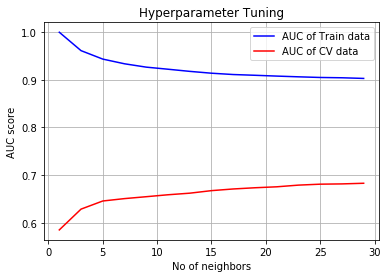

In [272]:
plt.close()
plt.plot(neighbors,tfidf_w2v_bf_train_auc_score_fe,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_w2v_bf_cv_auc_score_fe,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (Brute Force) on FE-TFIDF W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.68

In [274]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="brute",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_w2v_train_bf_fe_l,y_train_bf)


#prediction of training data
    
tfidf_w2v_bf_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_bf_fe_l)
fpr_tfidf_w2v_bf_train,tpr_tfidf_w2v_bf_train,t_tfidf_w2v_bf_train=roc_curve(y_train_bf,tfidf_w2v_bf_train_pred[:,1],pos_label=1)
tfidf_w2v_bf_train_auc_score_fe=roc_auc_score(y_train_bf,tfidf_w2v_bf_train_pred[:,1])
print("The train data AUC score after FE ="+str(tfidf_w2v_bf_train_auc_score_fe))
    
# testing of model

tfidf_w2v_bf_test_pred=knn_brute_force_final_model.predict_proba(tfidf_w2v_test_bf_fe_l)
fpr_tfidf_w2v_bf_test,tpr_tfidf_w2v_bf_test,t_tfidf_w2v_bf_test=roc_curve(y_test_bf,tfidf_w2v_bf_test_pred[:,1],pos_label=1)
tfidf_w2v_bf_test_auc_score_fe=roc_auc_score(y_test_bf,tfidf_w2v_bf_test_pred[:,1])
print("The test data AUC score After FE ="+str(tfidf_w2v_bf_test_auc_score_fe))

The train data AUC score after FE =0.903035135014187
The test data AUC score After FE =0.6767941397138227


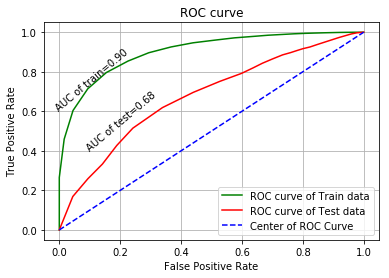

In [276]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_w2v_bf_train,tpr_tfidf_w2v_bf_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_w2v_bf_test,tpr_tfidf_w2v_bf_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.90",rotation=40,rotation_mode='anchor')
plt.text(0.1,0.4,"AUC of test=0.68",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

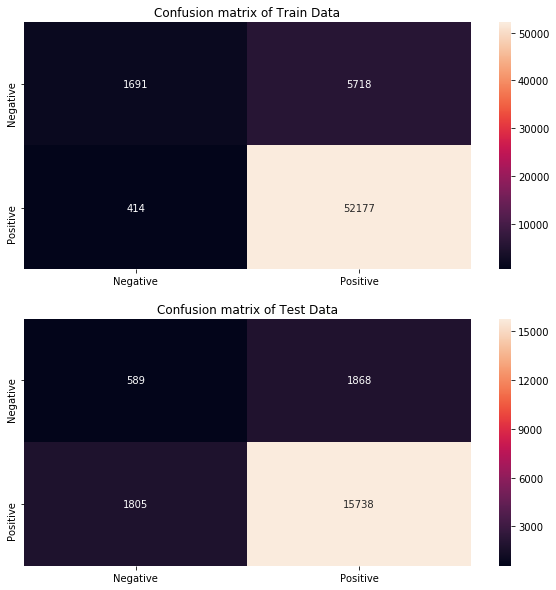

In [277]:
#  confusion matrix of training data
tfidf_w2v_bf_train_pred_cm_fe=np.argmax(tfidf_w2v_bf_train_pred,axis=1)
tfidf_w2v_bf_train_confusion_matrix_fe=confusion_matrix(y_train_bf,tfidf_w2v_bf_train_pred_cm_fe,labels=[0,1])
tfidf_w2v_bf_train_cm_fe=pd.DataFrame(tfidf_w2v_bf_train_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_w2v_bf_test_pred_cm_fe=np.argmax(tfidf_w2v_bf_test_pred,axis=1)
tfidf_w2v_bf_test_confusion_matrix_fe=confusion_matrix(y_test_bf,tfidf_w2v_bf_test_pred_cm_fe,labels=[0,1])
tfidf_w2v_bf_test_cm_fe=pd.DataFrame(tfidf_w2v_bf_test_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_w2v_bf_train_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_w2v_bf_test_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.68 of future unseen data

#### For KD Tree

In [293]:
# Hyperparameter tuning

neighbors=list(range(1,30,2))
tfidf_w2v_kd_train_auc_score_fe=[]
tfidf_w2v_kd_cv_auc_score_fe=[]
for i in tqdm(neighbors):
    knn_brute_force_model=KNeighborsClassifier(n_neighbors=i,algorithm="kd_tree",p=2)
    knn_brute_force_model.fit(tfidf_w2v_train_kd_fe_l,y_train_kd)
    
    #prediction of training data
    
    tfidf_w2v_kd_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_kd_fe_l)
    tfidf_w2v_kd_train_auc=roc_auc_score(y_train_kd,tfidf_w2v_kd_train_pred[:,1])
    tfidf_w2v_kd_train_auc_score_fe.append(tfidf_w2v_kd_train_auc)
    
    # prediction of cv data
    
    tfidf_w2v_kd_cv_pred=knn_brute_force_model.predict_proba(tfidf_w2v_cv_kd_fe_l)
    tfidf_w2v_kd_cv_auc=roc_auc_score(y_cv_kd,tfidf_w2v_kd_cv_pred[:,1])
    tfidf_w2v_kd_cv_auc_score_fe.append(tfidf_w2v_kd_cv_auc)

100%|█████████████████████████████████████████████████████████████████████████████████| 15/15 [57:56<00:00, 254.90s/it]


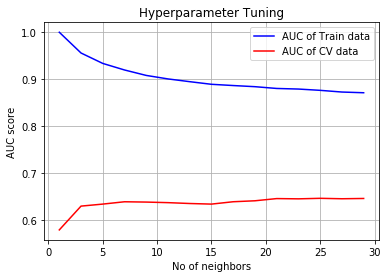

In [295]:
plt.close()
plt.plot(neighbors,tfidf_w2v_kd_train_auc_score_fe,"b",label="AUC of Train data")
plt.plot(neighbors,tfidf_w2v_kd_cv_auc_score_fe,"r",label="AUC of CV data")
plt.xlabel("No of neighbors")
plt.ylabel("AUC score")
plt.title("Hyperparameter Tuning")
plt.grid()
plt.legend()
plt.show()

##### Observation:

* when we apply the KNN (KD Tree) on TFIDF W2V, we got the best Hyperparameter of KNN model is K= 27, AUC= 0.65

In [298]:
# applying best or tuned hyperparameter on unseen dataset

knn_brute_force_final_model=KNeighborsClassifier(n_neighbors=27,algorithm="kd_tree",p=2)

# training of model

knn_brute_force_final_model.fit(tfidf_w2v_train_kd_fe_l,y_train_kd)


#prediction of training data
    
tfidf_w2v_kd_train_pred=knn_brute_force_model.predict_proba(tfidf_w2v_train_kd_fe_l)
fpr_tfidf_w2v_kd_train,tpr_tfidf_w2v_kd_train,t_tfidf_w2v_kd_train=roc_curve(y_train_kd,tfidf_w2v_kd_train_pred[:,1],pos_label=1)
tfidf_w2v_kd_train_auc_score_fe=roc_auc_score(y_train_kd,tfidf_w2v_kd_train_pred[:,1])
print("The train data AUC score="+str(tfidf_w2v_kd_train_auc_score_fe))
    
# testing of model

tfidf_w2v_kd_test_pred=knn_brute_force_final_model.predict_proba(tfidf_w2v_test_kd_fe_l)
fpr_tfidf_w2v_kd_test,tpr_tfidf_w2v_kd_test,t_tfidf_w2v_kd_test=roc_curve(y_test_kd,tfidf_w2v_kd_test_pred[:,1],pos_label=1)
tfidf_w2v_kd_test_auc_score_fe=roc_auc_score(y_test_kd,tfidf_w2v_kd_test_pred[:,1])
print("The test data AUC score="+str(tfidf_w2v_kd_test_auc_score_fe))

The train data AUC score=0.8710039830078973
The test data AUC score=0.6251829556036148


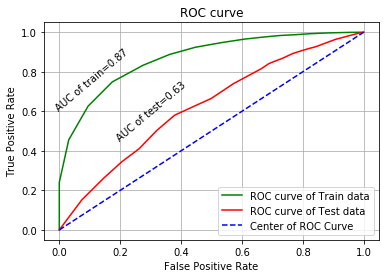

In [299]:
# ROC Curve for Both Train and Test data

plt.close()
plt.plot(fpr_tfidf_w2v_kd_train,tpr_tfidf_w2v_kd_train,"green",label="ROC curve of Train data")
plt.plot(fpr_tfidf_w2v_kd_test,tpr_tfidf_w2v_kd_test,"red",label="ROC curve of Test data")
plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.text(0,0.6,"AUC of train=0.87",rotation=40,rotation_mode='anchor')
plt.text(0.2,0.45,"AUC of test=0.63",rotation=40,rotation_mode='anchor')
plt.grid()
plt.title("ROC curve")
plt.legend()
plt.show()

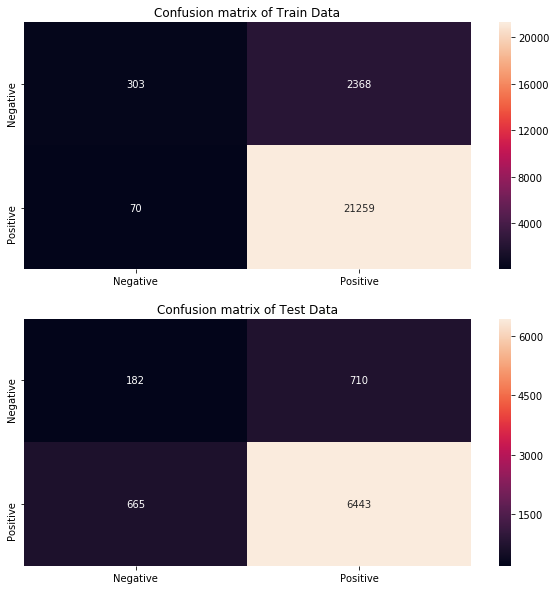

In [300]:
#  confusion matrix of training data
tfidf_w2v_kd_train_pred_cm_fe=np.argmax(tfidf_w2v_kd_train_pred,axis=1)
tfidf_w2v_kd_train_confusion_matrix_fe=confusion_matrix(y_train_kd,tfidf_w2v_kd_train_pred_cm_fe,labels=[0,1])
tfidf_w2v_kd_train_cm_fe=pd.DataFrame(tfidf_w2v_kd_train_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])

# confusion matrix of test data

tfidf_w2v_kd_test_pred_cm_fe=np.argmax(tfidf_w2v_kd_test_pred,axis=1)
tfidf_w2v_kd_test_confusion_matrix_fe=confusion_matrix(y_test_kd,tfidf_w2v_kd_test_pred_cm_fe,labels=[0,1])
tfidf_w2v_kd_test_cm_fe=pd.DataFrame(tfidf_w2v_kd_test_confusion_matrix_fe,index=["Negative","Positive"],columns=["Negative","Positive"])
plt.close()
plt.figure(1,figsize=(10,10))
plt.subplot(211)
sns.heatmap(tfidf_w2v_kd_train_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Train Data")
plt.subplot(212)
sns.heatmap(tfidf_w2v_kd_test_cm_fe,annot=True,fmt='d')
plt.title("Confusion matrix of Test Data")
plt.show()

##### Observation:

* When we apply the tuned hyperparameter(k=27) on trained model we got AUC score of test data= 0.63 of future unseen data

#### 8.2.5 Observation:

In [304]:
x = PrettyTable()
y=PrettyTable()
z=PrettyTable()

print("TFIDF Word2Vec Feature Engineering( Review Text + Summary)")
y.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
y.add_row(["TFIDF W2V","Brute Force",27,0.67])
y.add_row(["TFIDF W2V","KD Tree",27,0.62])
print(y)

print("TFIDF Word2Vec Feature Engineering (Review Text + Summary + Length)")
z.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
z.add_row(["TFIDF W2V","Brute Force",27,0.68])
z.add_row(["TFIDF W2V","KD Tree",27,0.63])
print(z)

TFIDF Word2Vec Feature Engineering( Review Text + Summary)
+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
| TFIDF W2V  | Brute Force |       27       | 0.67 |
| TFIDF W2V  |   KD Tree   |       27       | 0.62 |
+------------+-------------+----------------+------+
TFIDF Word2Vec Feature Engineering (Review Text + Summary + Length)
+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
| TFIDF W2V  | Brute Force |       27       | 0.68 |
| TFIDF W2V  |   KD Tree   |       27       | 0.63 |
+------------+-------------+----------------+------+


* After Applying feature engineering( Review Text + Summary + Length of Review Text) on model, the performance in terms of auc score does not affected by stacking a length feature.

### 9. Conclusion:

In [312]:
x = PrettyTable()

x.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
print ("1.Before Applying Feature Engineering on Model(Review Text)")
print(' ')
x.add_row(["BOW","Brute Force",27,0.76])
x.add_row(["TFIDF","Brute Force",27,0.83])
x.add_row(["Avg W2V","Brute Force",27,0.86])
x.add_row(["TFIDF W2V","Brute Force",27,0.62])
x.add_row(["BOW","KD Tree",27,0.78])
x.add_row(["TFIDF","KD Tree",27,0.78])
x.add_row(["Avg W2V","KD Tree",27,0.84])
x.add_row(["TFIDF W2V","KD Tree",27,0.61])
print(x)
print(' ')
x = PrettyTable()
y=PrettyTable()
z=PrettyTable()
print ("2.After Applying Feature Engineering on Model")
print(' ')
print("TFIDF Word2Vec Feature Engineering( Review Text + Summary)")
print(' ')
y.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
y.add_row(["TFIDF W2V","Brute Force",27,0.67])
y.add_row(["TFIDF W2V","KD Tree",27,0.62])
print(y)
print(' ')
print("TFIDF Word2Vec Feature Engineering (Review Text + Summary + Length)")
print(' ')
z.field_names = ["Vectorizer", "Model", "Hyperparameter", "AUC"]
z.add_row(["TFIDF W2V","Brute Force",27,0.68])
z.add_row(["TFIDF W2V","KD Tree",27,0.63])
print(z)

1.Before Applying Feature Engineering on Model(Review Text)
 
+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
|    BOW     | Brute Force |       27       | 0.76 |
|   TFIDF    | Brute Force |       27       | 0.83 |
|  Avg W2V   | Brute Force |       27       | 0.86 |
| TFIDF W2V  | Brute Force |       27       | 0.62 |
|    BOW     |   KD Tree   |       27       | 0.78 |
|   TFIDF    |   KD Tree   |       27       | 0.78 |
|  Avg W2V   |   KD Tree   |       27       | 0.84 |
| TFIDF W2V  |   KD Tree   |       27       | 0.61 |
+------------+-------------+----------------+------+
 
2.After Applying Feature Engineering on Model
 
TFIDF Word2Vec Feature Engineering( Review Text + Summary)
 
+------------+-------------+----------------+------+
| Vectorizer |    Model    | Hyperparameter | AUC  |
+------------+-------------+----------------+------+
| TFIDF W2V  | Brute Force |    

* After applying Feature Engineering on model, the performance of the model slighlty improved when stack the summary text and the length of the review text does not make any sense on the performance of the model.